# Projet P3 - Préparez des données pour un organisme de santé publique
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - Novembre 2023*
<hr>

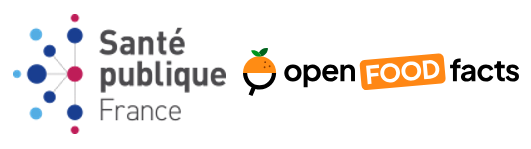

# <font color='#0a389f'>Introduction<a class="anchor" id="Presentation_projet"></a></font>

## <font color='#46abe6'>Contexte et mission</font>
L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts. Cette base de données open source est mise à la disposition de particuliers et d’organisations afin de leur permettre de connaître la qualité nutritionnelle de produits.
Aujourd’hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes dans la base. 

L’agence Santé publique France souhaite créer un système de suggestion ou d’auto-complétion pour aider les usagers à remplir plus efficacement la base de données. 

Le présent projet concerne les étapes de nettoyage et exploration des données, afin d'établir la faisabilité de suggérer les valeurs manquantes.

## <font color='#46abe6'>Données</font>
- Source :  [Open Food Facts](https://world.openfoodfacts.org/) 
- Informations sur les données : [Open Food Facts - Data Fields](https://world.openfoodfacts.org/data/data-fields.txt) 

## <font color='#46abe6'>Notebook</font>
Le présent Notebook concerne la partie 3 - Analyse exploratoire.

## <font color='#46abe6'>Sommaire</font>

<span style='background:#d5155b'><span style='color:white'>**Notebook Nettoyage**</span></span>

**Partie 1 - Importation et Inspection des données**
* 1.1. Importation des librairies
* 1.2. Définition des fonctions
* 1.3. Importation et inspection des données
* 1.4. Description du jeu de données
* 1.5. Données nutritionnelles

**Partie 2 - Nettoyage des données**
* 2.1. Filtrage des données
* 2.2. Types de variables
* 2.3. Doublons `code`
* 2.4. Homogénéisation des noms des modalités `pnns_groups_1`, `pnns_groups_2` et `main_category_fr`
* 2.5. Identification et traitement des valeurs aberrantes
* 2.6. Identification et traitement des valeurs manquantes
* 2.7. Change log - Modifications apportées au jeu de données
* 2.8. Conclusions & perspectives


<span style='background:#d5155b'><span style='color:white'>**Notebook Analyse exploratoire**</span></span>

**[Partie 3 - Analyse exploratoire](#partie3)**
* [3.1. Analyse univariée](#3_1)
* [3.2. Analyse bivariée](#3_2)
* [3.3. Analyse multivariée](#3_3)
* [3.4. Conclusion et Perspectives](#3_4)

## <font color='#46abe6'>Importation des librairies</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

# Tests statistiques
import scipy.stats as st
import researchpy as rp
import pingouin as pg

# PCA
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.26.0
pandas - 2.1.1
matplotlib - 3.8.0
seaborn - 0.13.0
plotly - 5.9.0
pingouin - 0.5.3
sklearn - 1.3.0


In [3]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height))
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

<Figure size 700x500 with 0 Axes>

In [4]:
# Options d'affichage : toutes les colonnes
pd.set_option('display.max_columns', None)

## <font color='#46abe6'>Définition des fonctions</font>

### Statistiques

In [5]:
def distribution_analysis(data, feature):
    """!
    @brief Analyse la distribution d'une variable d'un jeu de données'.

    Cette fonction prend en entrée un dataframe et le nom d'une variable à analyser.
    Elle génère un histogramme de la variable, identifie le(s) mode(s), évalue l'asymétrie (skewness)
    et le kurtosis de la distribution.

    @param data: type pd.DataFrame, DataFrame contenant les données à analyser.
    @param feature: type str, Nom de la variable à analyser.
    """

    # Histogramme 
    plt.hist(data[feature])
    plt.title(f'Histogramme de la variable {feature}')
    plt.xlabel(feature)
    plt.ylabel('Fréquence')
    plt.show()

    # Mode de la distribution
    mode = round(data[feature].mode(),1)
    
    mode_list = []
    # Ajouter les modes de la distribution à la liste
    for i in range(0,len(mode)):
        mode_list.append(mode.iloc[i])
    
    if len(mode) == 1:
        mode_qualifier = "Distribution unimodale"
    else:
        mode_qualifier = "Distribution multimodale"
        
    # Skewness : asymétrie de la distribution
    skewness = data[feature].skew()
    
    if skewness == 0:
        skewness_qualifier = "Symétrique"
    elif skewness > 0:
        skewness_qualifier = "Étalée à droite"
    else:
        skewness_qualifier = "Étalée à gauche"

    # Kurtosis : aplatissement dela distribution
    kurt = data[feature].kurtosis()
    if kurt == 0:
        kurtosis_qualifier = "Aplatissement similaire à une distribution normale"
    elif kurt > 0:
        kurtosis_qualifier = "Moins aplatie que la distribution normale: observations plus concentrées"
    else:
        kurtosis_qualifier = "Moins concentrées que la distribution normale: distribution plus aplatie"


    print(f"Variable : {feature}")
    print(f"Mode : {mode_list} ({mode_qualifier})")
    print(f"Skewness : {round(skewness,2)} ({skewness_qualifier})")
    print(f"Kurtosis : {round(kurt,2)} ({kurtosis_qualifier})")
    print("\n")

In [6]:
def q1(x):
    """!
    @brief Calcule le premier quartile d'une série de données.

    Cette fonction prend une série de données en entrée et retourne le premier quartile (Q1),
    qui représente la valeur en-dessous de laquelle 25% des données se situent.

    @param x: Série de données (pandas Series).
    @return x.quantile(0.25): Premier quartile de la série x.
    """

    return x.quantile(0.25)

def q3(x):
    """!
    @brief Calcule le troisième quartile d'une série de données.

    Cette fonction prend une série de données en entrée et retourne le troisième quartile (Q3),
    qui représente la valeur en-dessous de laquelle 75% des données se situent.

    @param x: Série de données (pandas Series).
    @return x.quantile(0.75): Troisième quartile de la série x.
    """

    return x.quantile(0.75)

In [7]:
def stats(df, indicator, var, colors, showfliers):
    """!
    @brief Affiche pour chaque indicateur une table avec les statistiques et un boxplot par modalité de la variable.

    Cette fonction génère une table contenant les statistiques des indicateurs et affiche un boxplot pour chaque indicateur,
    regroupé par modalité de la variable spécifiée. Elle appelle les fonctions q1() et q3() pour afficher le premier et 
    le troisième quantiles.

    @param df: Dataframe contenant les données (pandas DataFrame).
    @param indicator: Liste contenant les noms des indicateurs à analyser (list de str).
    @param var: Variable utilisée pour le regroupement (str).
    @param colors: Liste des couleurs à utiliser pour le graphique (list de str).
    @param showfliers: True or False, pour l'affichage des outliers.
    """

    # Statistiques descriptives à afficher
    stats = ['count','mean', 'std', 'min', q1, 'median', q3, 'max']
    # Caractéristiques d'affichage de meanprops
    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

    # Boucle pour afficher pour chaque indicateur : une table avec les statistiques et un boxplot par var
    for ind in indicator:
        # Affichage des statistiques sous forme de table
        display(round(df.groupby(var).agg({ind: stats}),2))

        # Création et affichage du boxplot
        sns.boxplot(data=df.sort_values(var), 
                    x=ind, 
                    y=var, 
                    hue=var, 
                    showfliers=showfliers, 
                    showmeans=True, 
                    meanprops=meanprops,
                    palette=colors,
                    legend=False)
        plt.title(ind+" : Distribution par "+var)
        plt.show()

In [8]:
def normality_test(df, var):
    """!
    @brief Effectue un test de normalité sur une variable d'un dataframe et affiche un graphique comparatif.

    Cette fonction teste si la variable `var` du dataframe `df` suit une distribution normale en utilisant 
    soit le test de Shapiro-Wilk (pour des échantillons de taille inférieure ou égale à 5000), soit le test de 
    Kolmogorov-Smirnov (pour des échantillons de taille supérieure à 5000).
    Elle affiche également un graphique comparatif entre la distribution normale théorique et la distribution réelle 
    de la variable.

    @param df: DataFrame contenant la variable à tester
    @param var: string, Nom de la variable à tester

    @return result: booléen,  Renvoie True si la variable suit une distribution normale, False sinon
    """
    # Extraction des valeurs non nulles de la variable
    X = df.loc[df[var].notna(), var]

    # Distribution normale de X
    x_min = 0.0
    x_max = max(X)
    mean = X.mean()
    std = X.std()
    x = np.linspace(x_min, x_max, 100)
    y = st.norm.pdf(x, mean, std)

    # Représentation graphique de la distribution normale et réelle de X
    plt.plot(x, y, color='blue', label='Distribution normale')
    sns.kdeplot(X, fill=True, label=var)
    plt.title(f'{var}: comparaison avec une distribution normale', fontsize=10)
    plt.xlabel(var)
    plt.ylabel('Densité')
    plt.legend()
    plt.show()
    
    result = ''
    alpha = 0.05
    
    # Test de normalité
    if len(X) <= 5000:
        # Test de Shapiro - Wilk
        stat, p = st.shapiro(X)
        print('Test de Shapiro - Wilk : stat = %.3f , p=%.3f \n' % (stat, p))
            
    else:
        # Test de Kolmogorov-Smirnov
        stat, p = st.kstest(X, 'norm')
        print('Test de Kolmogorov-Smirnov : stat = %.3f , p=%.3f \n' % (stat, p))

    if p < alpha:  # H0 : la variable suit la loi normale de distribution
        print(f"p-value < {alpha}, H0 peut être rejetée : la distribution ne suit pas la loi normale.")
        result = False
    else:
        print(f"p-value>= {alpha}, H0 est acceptée : la distribution suit la loi normale")
        result = True
            
    return result

In [9]:
def variance_test(df, var, group):
    """!
    @brief Effectue un test d'égalité des variances entre les groupes d'une variable d'un dataframe.

    Cette fonction teste l'hypothèse nulle selon laquelle les variances de la variable `var` entre les groupes définis 
    par la colonne `group` du dataframe `df` sont égales. Elle affiche la variance globale de la variable et les résultats 
    du test d'homoscédasticité. Enfin, elle retourne un booléen indiquant si les variances sont considérées comme égales.

    @param df: DataFrame de type pd.DataFrame contenant la variable et la colonne de groupe
    @param var: Nom de la variable à tester, de type str
    @param group: Nom de la colonne de groupe, de type str

    @return: Renvoie True si les variances sont considérées comme égales, False sinon (de type bool)
    """
    X = df.loc[df[var].notna(), var]
    df_notna = df.loc[df[var].notna()]

    # Test d'homoscédasticité
    homoscedasticity = pg.homoscedasticity(data=df_notna, dv=var, group=group, alpha=0.05)
    print(f'Variable : {var}')
    print("Variance = %.3f" % np.var(X))
    display(homoscedasticity.round(3))

    equal_var = homoscedasticity.iloc[0, 2]
    if not equal_var:  # H0 : les variances des groupes ne sont pas égales
        print(f"H0 peut être rejetée : les variances de la variable {var} pour les groupes {group} ne sont pas égales")
    else:
        print(f"H0 est acceptée : les variances de la variable {var} pour les groupes {group} sont égales")

    return equal_var

In [10]:
def anova_test(df, var, group):
    """!
    @brief Effectue un test d'analyse de la variance (ANOVA) avec des tests post-hoc en fonction de la normalité et 
    de l'égalité des variances.

    Cette fonction réalise un test d'analyse de la variance (ANOVA) sur la variable `var` entre les groupes définis par 
    la colonne `group` du dataframe `df`. Elle effectue des tests de normalité et d'égalité des variances en appelant les
    fonctions normality_test() et variance_test(), puis sélectionne le test ANOVA approprié en fonction des résultats. 
    Enfin, elle affiche les résultats du test ANOVA et, le cas échéant, les résultats des tests post-hoc.

    @param df: DataFrame de type pd.DataFrame contenant la variable et la colonne de groupe
    @param var: Nom de la variable à tester, de type str
    @param group: Nom de la colonne de groupe, de type str
    """
    print('Test de normalité')
    normality = normality_test(df, var)
    print("-" * 100)
    print("Test d'égalité des variances")
    homoscedasticity = variance_test(df, var, group)
    
    # Risque de première espèce
    alpha = 0.05

    print("-" * 100)
    if normality:
        if homoscedasticity:
            print("Test ANOVA")
            # One-way ANOVA
            anova = pg.anova(data=df, dv=var, between=group).round(3)
            display(anova)
            p = anova.iloc[0, 4]
            if p < alpha:  # H0 : les moyennes des groupes sont égales
                print(f"p-value < {alpha}, H0 peut être rejetée : les moyennes de la variable {var} pour les groupes "\
                      f"{group} ne sont pas égales")
                # Post-hoc Tukey test
                print('')
                print("\nPost-hoc Tukey test")
                display(pg.pairwise_tukey(data=df, dv=var, between=group).round(3))
            else:
                print(f"p-value >= {alpha}, H0 est acceptée : les moyennes de la variable {var} pour les groupes {group} "\
                      "sont égales")

        else:
            # Welch-Anova
            print("Test Welch ANOVA")
            anova = pg.welch_anova(data=df, dv=var, between=group).round(3)
            display(anova)
            p = anova.iloc[0, 4]
            if p < alpha:  # H0 : les moyennes des groupes sont égales
                print(f"p-value < {alpha}, H0 peut être rejetée : les moyennes de la variable {var} pour les groupes "\
                      f"{group} ne sont pas égales")
                # Post-hoc Games Howell
                print('')
                print("\nPost-hoc Games Howell")
                display(pg.pairwise_gameshowell(data=df, dv=var, between=group).round(3))
            else:
                print(f"p-value >= {alpha}, H0 est acceptée : les moyennes de la variable {var} pour les groupes {group} "\
                      "sont égales")

    else:
        # Kurkal-Wallis
        print("Test Kruskal-Wallis")
        anova = pg.kruskal(data=df, dv=var, between=group).round(3)
        display(anova)
        p = anova.iloc[0, 3]
        if p < alpha:  # H0 : les médianes des groupes ne sont pas égales
            print(f"p-value < {alpha}, H0 peut être rejetée : les médianes de la variable {var} pour les groupes {group} "\
                  "ne sont pas égales")
            # Post-hoc Pairwise_tests
            print('')
            print("\nPost-hoc Pairwise_tests")
            display(pg.pairwise_tests(data=df, dv=var, between=group, parametric=False).round(3))
        else:
            print(f"p-value >= {alpha}, H0 est acceptée : les médianes de la variable {var} pour les groupes {group} "\
                  "sont égales")

In [11]:
def correlation_test(df, var1, var2):
    """!
    @brief Effectue un test de corrélation entre deux variables d'un dataframe df.

    Cette fonction prend en entrée un dataframe (`df`) ainsi que les noms de deux variables
    à analyser (`var1` et `var2`). Elle effectue un test de normalité en appelant la fonction normality_test
    pour chacune des variables, puis utilise le coefficient de corrélation de Pearson si les distributions sont normales,
    sinon elle utilise le coefficient de rang de Spearman.

    Les résultats du test sont affichés, y compris le coefficient de corrélation, la p-value, la qualification de la 
    relation et le rejet ou non de l'hypothèse H0.

    @param df: type pd.DataFrame, DataFrame contenant les données.
    @param var1: type str, Nom de la première variable à analyser.
    @param var2: type str, Nom de la deuxième variable à analyser.
    """
    
    # Ecarter les valeurs nulles
    df_test = df.dropna(subset = [var1, var2], how = 'any')

    # Test de normalité de la distribution {var1}
    print(f'Test de normalité de la distribution de {var1}')
    normality_var1 = normality_test(df_test, var1)
    print("-" * 100)
    
    # Test de normalité de la distribution {var2}
    print(f'Test de normalité de la distribution de {var2}')
    normality_var2 = normality_test(df_test, var2)
    print("-" * 100)
    
    # Risque de première espèce
    alpha = 0.05
    
    if normality_var1 and normality_var2: # si les distributions suivent la loi normale
        # Pearson
        print("Coefficient de corrélation de Pearson")
        
        # Calcul du coefficient de Pearson et de la p-value
        coeff, pvalue=st.pearsonr(df_test[var1],df_test[var2])
        print("Le coefficient de corrélation de Pearson est égal à :",round(coeff,2))
        
    else:
        # Non paramétrique Coefficent de rang de Spearman
        print("Coefficient de rang de Spearman")
        
        # Calcul du coefficient de rang de Spearmanet de la p-value
        coeff, pvalue = st.spearmanr(df_test[var1],df_test[var2])
        print("Le coefficient de corrélation de Pearson est égal à :",round(coeff,2))
        print(f"p-value={pvalue}")
        
    # Analyse des résultats du test
    
    # Force de la relation
    if np.abs(coeff) <=0.5:
        force = 'faible'
    elif 0.5 < np.abs(coeff) < 1:
        force = 'forte'
    else:
        force = 'parfaite'
    
    # Signe de la relation
    if coeff < 0:
        signe = 'négative'
    else:
        signe = 'positive'
     
    # H0 : il n'y a pas de relation linéaire significative entre les variables
    if pvalue < alpha:  
        print(f"p-value < {alpha}, H0 est rejetée: il existe une relation linéaire significative "\
                  f"entre les variables {var1} et {var2}.")
        print(f"Les 2 variables ont une {force} corrélation {signe}.")
    else:
        print(f"p-value >= {alpha}, H0 est acceptée: il n'existe pas de relation linéaire significative "\
                  f"entre les variables {var1} et {var2}.")

In [12]:
def chi2_test(df, var1, var2):
    """!
    @brief Effectue un test du Chi-2 d'indépendance entre deux variables catégorielles.

    Cette fonction prend en entrée un dataframe (`df`) ainsi que les noms de deux variables
    catégorielles (`var1` et `var2`). Elle génère une table de contingence, effectue le test du Chi-2
    et calcule le coefficient V de Cramer pour mesurer l'intensité de la relation entre les variables.

    Les résultats du test, y compris le Chi-2, la p-value, le degré de liberté, le V de Cramer, et
    l'intensité de la relation sont affichés à l'écran.

    @param df: type pd.DataFrame, Dataframe contenant les données.
    @param var1: type str, Nom de la première variable catégorielle à analyser.
    @param var2: type str, Nom de la deuxième variable catégorielle à analyser.
    """
    
    # Table des contingences
    cont = df[[X,Y]].pivot_table(index=var1,columns=var2,aggfunc=len)
    
    # Chi-2 et pvalue 
    chi2, pvalue, dof, expected = st.chi2_contingency(cont)

    # Calcul du V de Cramer
    sample_size = np.sum(cont.values)
    min_dim = min(cont.values.shape) - 1
    cramer_V = np.sqrt(chi2 / (sample_size * min_dim))

    # Résultats du test du Chi-2 et V de Cramer
    print("Résultats du test d'intépendance du Chi-2 et du test de Cramer pour l'intensité de la relation")
    print("-"*50)
    print(f"Le degré de liberté est de {dof}")
    print(f"Chi-2 = {round(chi2,2)}")
    print(f"pvalue = {round(pvalue,2)}")
    print(f"V de Cramer = {round(cramer_V,2)}")
    print("")
    
    # Intensité de la relation
    if 0.3 <= cramer_V :
        intensite = 'forte'
    elif 0.20 <= cramer_V < 0.3:
        intensite = 'moyenne'
    elif 0.10 <= cramer_V < 0.20:
        intensite = 'faible'
    elif cramer_V < 0.10:
        intensite = 'nulle ou très faible'  
    
    # Vérifier que les valeurs attendues sont > 5
    min_attendu = expected.min().min()
    
    # Risque de première espèce
    alpha = 0.05
        
    # Rejet ou non de H0 : Les variables sont indépendantes
    if pvalue < alpha:  
        print(f"pvalue < {alpha}, H0 est rejetée: les variables {var1} et {var2} ne sont pas indépendantes.")
        print(f"L'intensité de la relation est {intensite}.")
    else:
        print(f"p-value > {alpha}, H0 est acceptée:  les variables {var1} et {var2} sont indépendantes.")
        
    if min_attendu<=5:
        print("/!\ Il y a des valeurs attendues < 5.")
    else:
        print("Toutes les valeurs attendues sont > 5.")

### Graphiques l'Analyse en Composantes Principales

In [13]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """!
    @brief Affiche le graphe des correlations de l'ACP

    Cette fonction permet l'affichage du cercle des corrélations de l'ACP pour un objet pca qui a été fit, 
    un couple X_y de composantes principales, et les features.

    @param pca: L'objet sklearn.decomposition.PCA qui a été fit
    @param x_y: Le couple x,y, list ou tuple, des plans à afficher, exemple [0,1] pour PC1, PC2
    @param features: La liste, list ou tuple, des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(15, 11))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (PC{} et PC{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [14]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker=".",
                                palette=None):
    """!
    @brief Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    @param X_projected: np.array, pd.DataFrame, list of list : la matrice des points projetés
    @param x_y: list ou tuple, le couple x,y des plans à afficher, exemple [0,1] pour PC1, PC2

    Optional arguments : 
    -------------------------------------
    @ param pca: sklearn.decomposition.PCA, un objet PCA qui a été fit, 
    cela nous permettra d'afficher la variance de chaque composante, default = None
    
     @ param labels: list ou tuple, les labels des individus à projeter, default = None
     @ param clusters: list ou tuple, la liste des clusters auquel appartient chaque individu, default = None
     @ param alpha: float in [0,1], paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
     @ param figsize: list ou tuple,couple width, height qui définit la taille de la figure en inches, default = [10,8] 
     @ param marker: str, le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
     @ param palette: list, palette de couleurs
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # Forme de la figure
    if not figsize: 
        figsize = (7,6)

    # Labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # Vérification de la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # Définition de x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Vérification de la présence de clustrers ou non
    c = None if clusters is None else clusters
    
    # Vérification de la présence de palette de couleur ou non
    p = None if palette is None else palette
 
    # Les points    
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=p)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'PC{x+1} {v1}')
    ax.set_ylabel(f'PC{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # Bornes pour x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur PC{x+1} et PC{y+1})")
    plt.show()

## <font color='#46abe6'>Importation du dataframe nettoyé</font>

In [15]:
frfoodfacts_df = pd.read_pickle('frfoodfacts_df.pkl')

# <font color='#0a389f'>Partie 3 - Analyse exploratoire<a class="anchor" id="partie3"></a></font>

In [16]:
colors_groups = sns.color_palette('tab10')

## <font color='#46abe6'>3.1. Analyse univariée<a class="anchor" id="3_1"></a></font>

In [17]:
nutri_features = [
'energy_100g',
'fat_100g',
'saturated-fat_100g',
'carbohydrates_100g',
'sugars_100g',
'fiber_100g',
'proteins_100g',
'salt_100g',
'sodium_100g',
'fruits-vegetables-nuts_100g',
'nutrition-score-fr_100g'
]

In [18]:
round(frfoodfacts_df[nutri_features].describe(),1)

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
count      66027.0   47387.0             64077.0             46959.0   
mean        1105.4      13.1                 5.2                27.4   
std          768.0      16.7                 8.3                27.4   
min            0.0       0.0                 0.0                 0.0   
25%          430.0       1.2                 0.3                 3.8   
50%         1053.0       6.6                 1.8                14.0   
75%         1628.0      21.0                 7.0                53.0   
max         4987.0     100.0               100.0               100.0   

       sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
count      64176.0     50461.0        65803.0    63827.0      61754.0   
mean          14.6         2.4            7.5        1.1          0.4   
std           20.1         4.1            7.8        4.0          1.6   
min            0.0         0.0            0.0        0.0          0.0   
25%            1.0         0.0            1.4        0.1          0.0   
50%            4.3         1.5            5.8        0.5          0.2   
75%           21.0         3.0           10.3        1.2          0.5   
max          100.0       100.0           95.0      100.0         39.4   

       fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
count                      13013.0                  62719.0  
mean                          18.7                      8.8  
std                           23.1                      8.9  
min                            0.0                    -15.0  
25%                            0.0                      1.0  
50%                            7.8                      9.0  
75%                           35.8                     15.0  
max                          100.0                     40.0

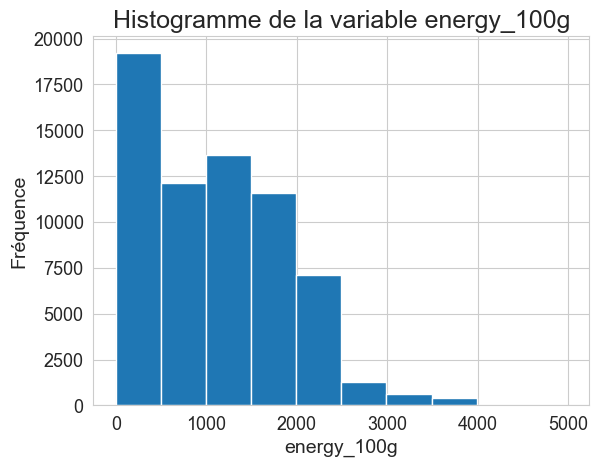

Variable : energy_100g
Mode : [1187.9] (Distribution unimodale)
Skewness : 0.61 (Étalée à droite)
Kurtosis : 0.01 (Moins aplatie que la distribution normale: observations plus concentrées)




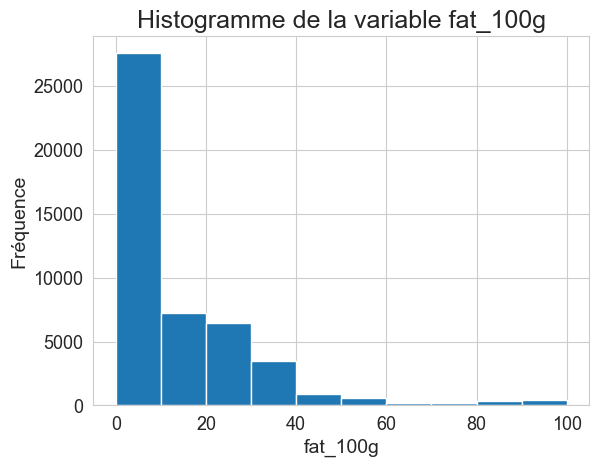

Variable : fat_100g
Mode : [0.0] (Distribution unimodale)
Skewness : 2.25 (Étalée à droite)
Kurtosis : 6.71 (Moins aplatie que la distribution normale: observations plus concentrées)




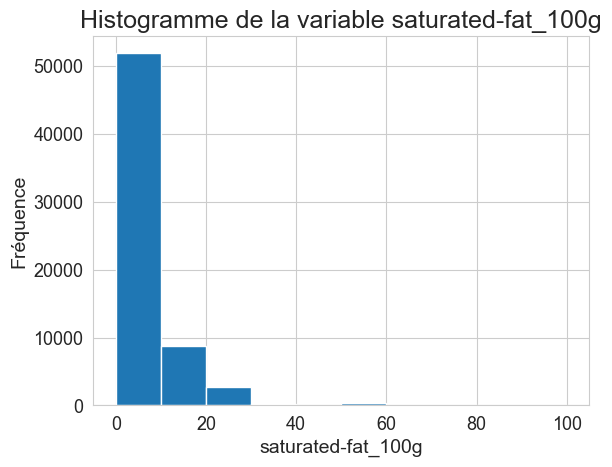

Variable : saturated-fat_100g
Mode : [0.0] (Distribution unimodale)
Skewness : 3.58 (Étalée à droite)
Kurtosis : 21.21 (Moins aplatie que la distribution normale: observations plus concentrées)




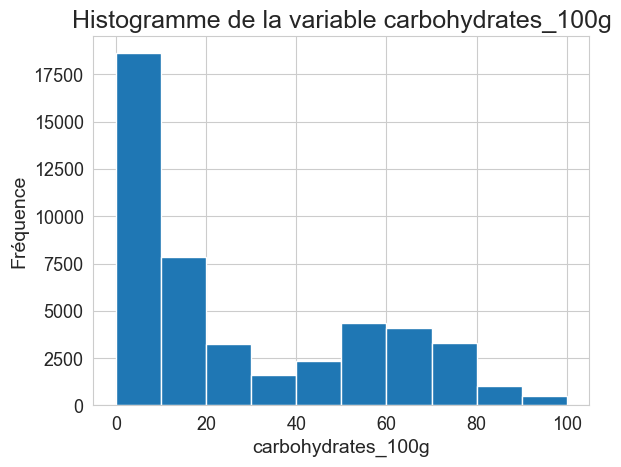

Variable : carbohydrates_100g
Mode : [0.0] (Distribution unimodale)
Skewness : 0.72 (Étalée à droite)
Kurtosis : -0.91 (Moins concentrées que la distribution normale: distribution plus aplatie)




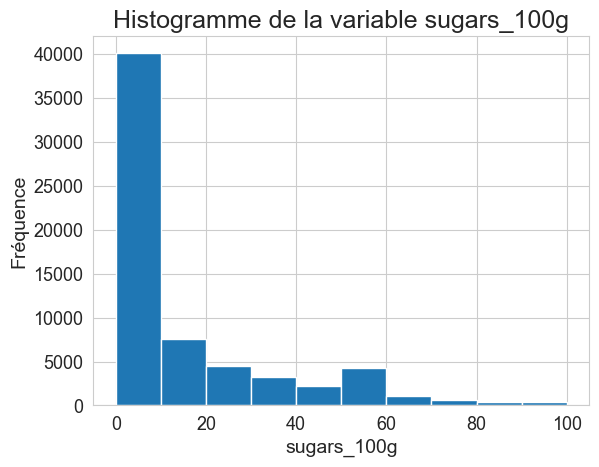

Variable : sugars_100g
Mode : [0.0] (Distribution unimodale)
Skewness : 1.68 (Étalée à droite)
Kurtosis : 2.15 (Moins aplatie que la distribution normale: observations plus concentrées)




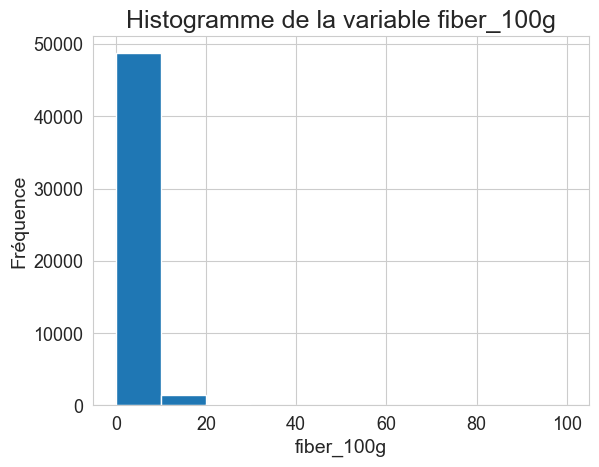

Variable : fiber_100g
Mode : [0.0] (Distribution unimodale)
Skewness : 6.67 (Étalée à droite)
Kurtosis : 84.26 (Moins aplatie que la distribution normale: observations plus concentrées)




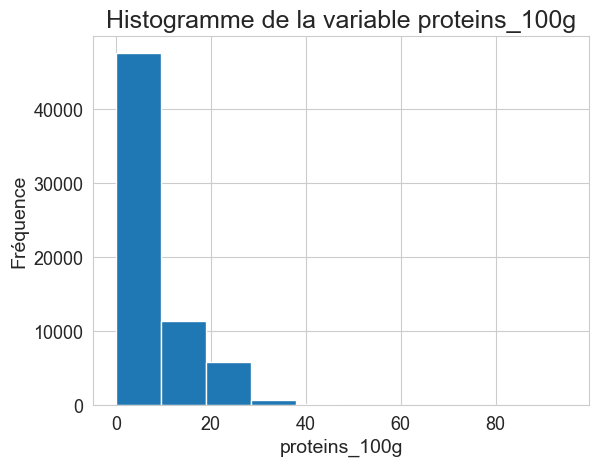

Variable : proteins_100g
Mode : [0.0] (Distribution unimodale)
Skewness : 2.16 (Étalée à droite)
Kurtosis : 10.06 (Moins aplatie que la distribution normale: observations plus concentrées)




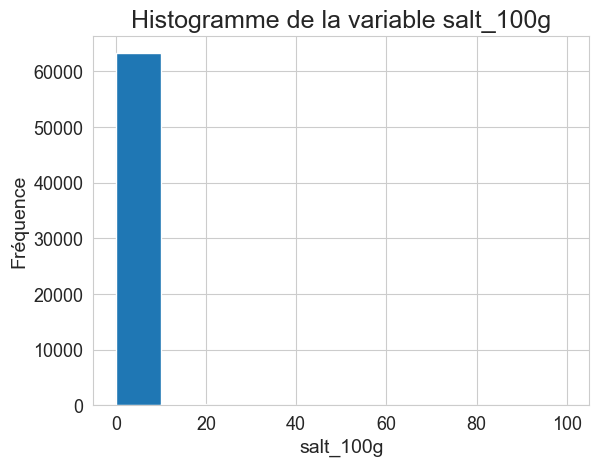

Variable : salt_100g
Mode : [0.0] (Distribution unimodale)
Skewness : 16.1 (Étalée à droite)
Kurtosis : 321.84 (Moins aplatie que la distribution normale: observations plus concentrées)




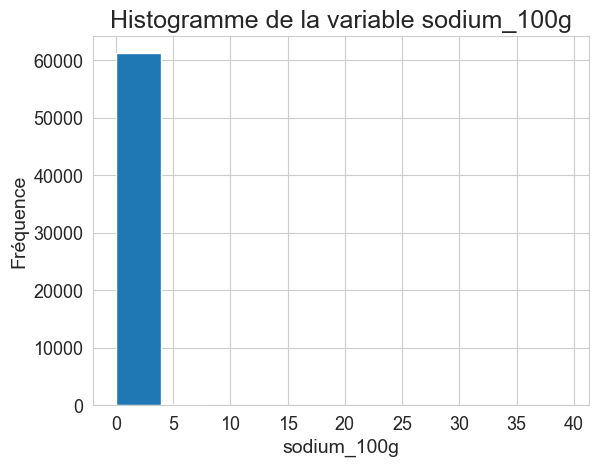

Variable : sodium_100g
Mode : [0.0] (Distribution unimodale)
Skewness : 15.87 (Étalée à droite)
Kurtosis : 312.08 (Moins aplatie que la distribution normale: observations plus concentrées)




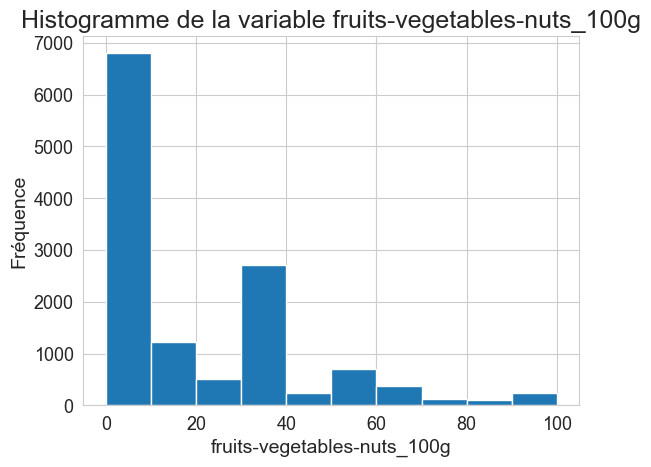

Variable : fruits-vegetables-nuts_100g
Mode : [0.0] (Distribution unimodale)
Skewness : 1.27 (Étalée à droite)
Kurtosis : 1.32 (Moins aplatie que la distribution normale: observations plus concentrées)




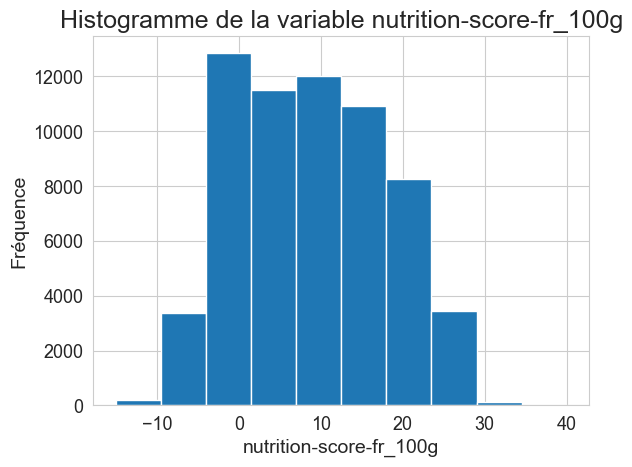

Variable : nutrition-score-fr_100g
Mode : [0.0] (Distribution unimodale)
Skewness : 0.16 (Étalée à droite)
Kurtosis : -0.89 (Moins concentrées que la distribution normale: distribution plus aplatie)




In [19]:
for fact in nutri_features:
    distribution_analysis(frfoodfacts_df, fact)

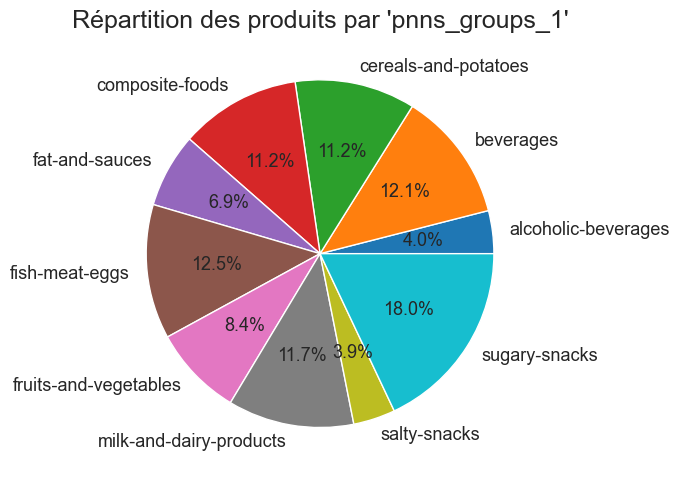

In [20]:
# Répartition des produits par pnns_groups
fig, ax = plt.subplots(1,1,figsize=(10,5))
 
# Répartition des produits par pnns_groups_1
df_pnns_groups = frfoodfacts_df.groupby('pnns_groups_1')['code'].count().reset_index().sort_values('pnns_groups_1')
labels_groups = df_pnns_groups['pnns_groups_1']

ax.pie(x=df_pnns_groups['code'],                                   
         colors = colors_groups,
         labels = labels_groups,
         autopct='%.1f%%')
ax.set_title("Répartition des produits par 'pnns_groups_1'")

plt.tight_layout()
plt.show()

In [21]:
df_nutrigrade = frfoodfacts_df.copy()
df_nutrigrade['nutrition_grade_fr'] = df_nutrigrade['nutrition_grade_fr'].fillna('non renseigné') 
df_nutrigrade = df_nutrigrade['nutrition_grade_fr'].value_counts().reset_index().sort_values('nutrition_grade_fr')
display(df_nutrigrade)

nutrition_grade_fr  count
4                  a  10429
5                  b   9104
2                  c  13121
1                  d  16954
3                  e  11721
0      non renseigné  18920

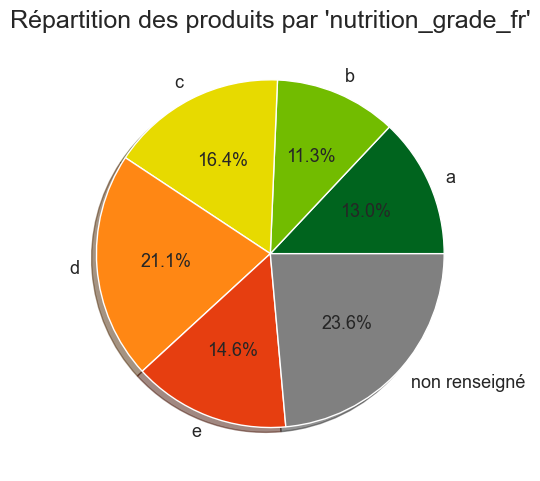

In [22]:
# Répartition des produits par pnns_groups
fig, ax = plt.subplots(1,1,figsize=(10,5))
 
# Répartition des produits par nutrigrade
labels_nutri = df_nutrigrade['nutrition_grade_fr'].sort_values()

ax.pie(x=df_nutrigrade['count'],                                   
         colors = ['#00641E', '#72BC00', '#E7DA00', '#FF8714', '#E63E10', 'grey'],
         labels = labels_nutri,
         autopct='%.1f%%', 
         shadow = True)
ax.set_title("Répartition des produits par 'nutrition_grade_fr'")

plt.tight_layout()
plt.show()

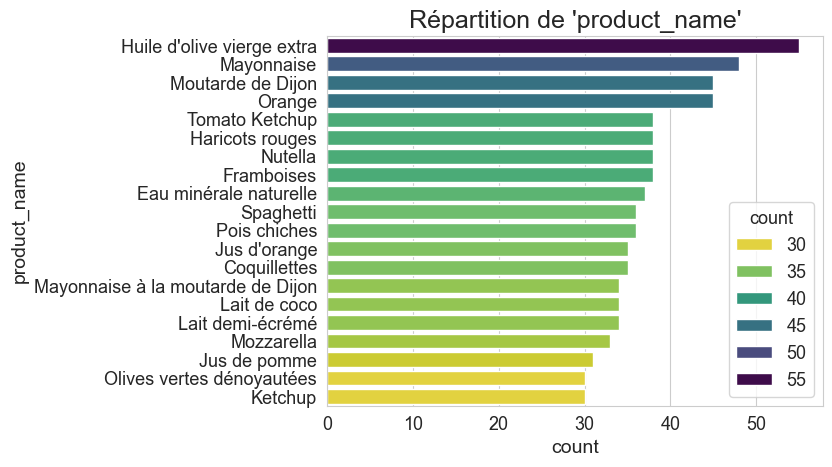

In [23]:
# Produits les plus fréquents
product_name_freq = frfoodfacts_df['product_name'].value_counts().reset_index()

df_graph = product_name_freq.sort_values('count', ascending=False).head(20)
sns.barplot(data= df_graph, x= 'count', y= 'product_name' , hue='count', palette = "viridis_r")
plt.title("Répartition de 'product_name'")
plt.show()

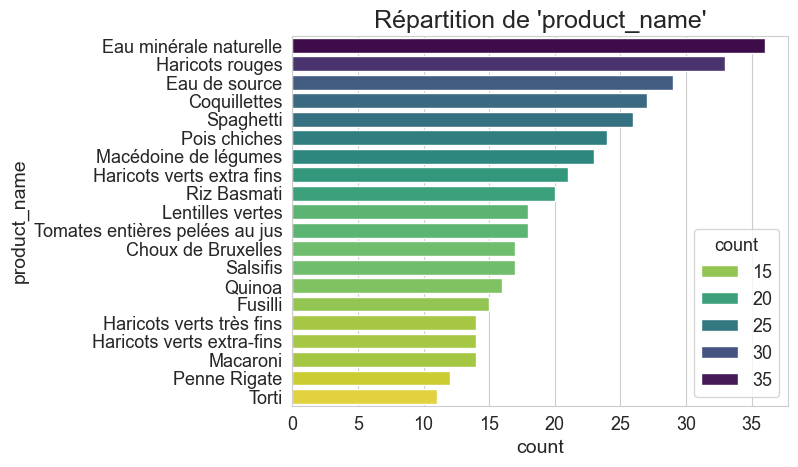

In [24]:
# Produits les plus fréquents avec un nutriscore 'a'
product_name_nutria = frfoodfacts_df.loc[frfoodfacts_df['nutrition_grade_fr']=='a', 
                                       'product_name'].value_counts().reset_index()

df_graph = product_name_nutria.sort_values('count', ascending=False).head(20)
sns.barplot(data= df_graph, x= 'count', y= 'product_name' , hue='count', palette = "viridis_r")
plt.title("Répartition de 'product_name'")
plt.show()

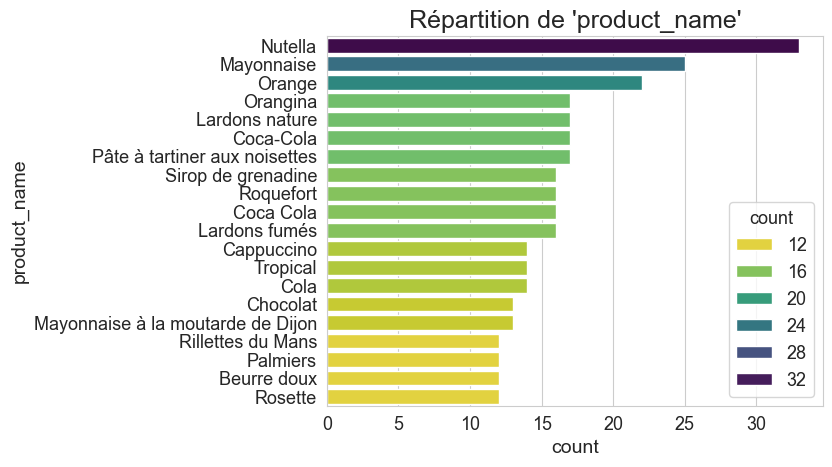

In [25]:
# Produits les plus fréquents avec un nutriscore 'a'
product_name_nutrie = frfoodfacts_df.loc[frfoodfacts_df['nutrition_grade_fr']=='e', 
                                       'product_name'].value_counts().reset_index()

df_graph = product_name_nutrie.sort_values('count', ascending=False).head(20)
sns.barplot(data= df_graph, x= 'count', y= 'product_name' , hue='count', palette = "viridis_r")
plt.title("Répartition de 'product_name'")
plt.show()

## <font color='#46abe6'>3.2. Analyse bivariée<a class="anchor" id="3_2"></a></font>

#### Représentation de la distribution des variables nutritionnelles en fonction des groupes `pnns_groups_1`

Il reste encore beaucoup de valeurs atypiques dans les pnns_groups_1 :  une méthode du Z-score par groupe 'pnns_groups_1' et par variable nutritionnelle. 

energy_100g                                           \
                              count     mean      std   min       q1  median   
pnns_groups_1                                                                  
alcoholic-beverages              96   378.70   364.93   0.0   151.00   195.0   
beverages                      5064   256.62   368.55   0.0   100.00   180.0   
cereals-and-potatoes           5399  1366.52   456.03  70.0  1158.00  1500.0   
composite-foods                5423   698.09   347.62  31.0   451.50   644.0   
fat-and-sauces                 2995  1639.82  1259.09   0.0   444.95  1252.0   
fish-meat-eggs                 4963   861.76   448.75   0.0   497.50   782.0   
fruits-and-vegetables          3359   394.88   507.04  11.0   119.00   224.0   
milk-and-dairy-products        5420   849.63   494.95   1.0   397.00   782.0   
salty-snacks                   1874  2085.55   482.30   0.0  1979.25  2157.5   
sugary-snacks                  9753  1678.89   508.44   0.0  1187.89  1725.0   

                                          
                              q3     max  
pnns_groups_1                             
alcoholic-beverages       506.50  1368.0  
beverages                 213.00  2954.0  
cereals-and-potatoes     1613.00  3770.0  
composite-foods           921.15  3054.0  
fat-and-sauces           2980.00  3772.0  
fish-meat-eggs           1077.00  4485.0  
fruits-and-vegetables     335.00  4117.0  
milk-and-dairy-products  1265.25  3912.0  
salty-snacks             2308.00  3707.0  
sugary-snacks            2110.00  4410.0

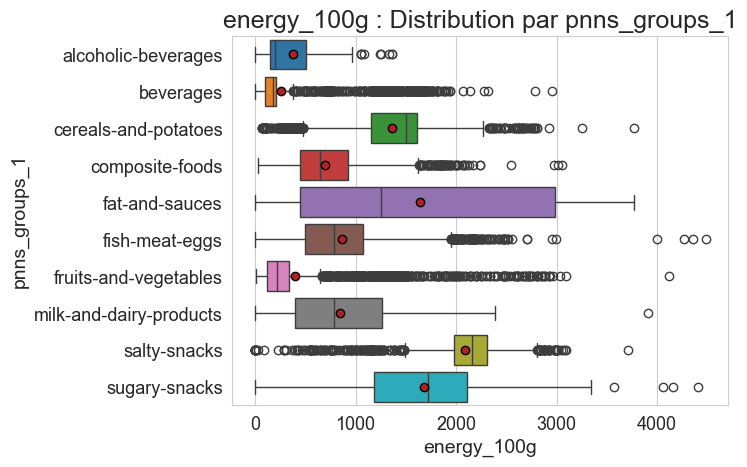

fat_100g                                              
                           count   mean    std  min    q1 median     q3    max
pnns_groups_1                                                                 
alcoholic-beverages           63   2.40   5.67  0.0   0.0    0.0   0.55   30.0
beverages                   4364   0.65   2.63  0.0   0.0    0.0   0.20   38.0
cereals-and-potatoes        5123   5.56   7.28  0.0   1.5    2.9   6.80   85.0
composite-foods             5265   7.70   5.34  0.0   4.0    6.8  10.10   70.0
fat-and-sauces              2820  40.10  36.83  0.0   3.7   28.1  80.00  100.0
fish-meat-eggs              4808  13.58  11.85  0.0   3.4   11.0  20.00   70.0
fruits-and-vegetables       3142   2.33   8.09  0.0   0.2    0.5   0.90   74.0
milk-and-dairy-products     5461  14.81  11.85  0.0   3.1   12.0  26.00   60.0
salty-snacks                1794  30.14  14.27  0.0  21.7   30.0  36.00   73.3
sugary-snacks               7533  18.89  13.50  0.0   5.0   20.5  29.00   73.7

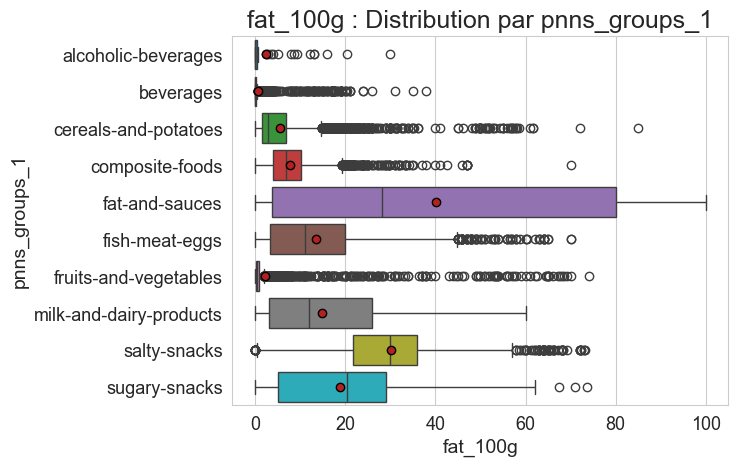

saturated-fat_100g                                  \
                                     count   mean    std  min    q1 median   
pnns_groups_1                                                                
alcoholic-beverages                     60   1.22   3.14  0.0  0.00    0.0   
beverages                             4829   0.42   2.46  0.0  0.00    0.0   
cereals-and-potatoes                  5162   1.62   2.57  0.0  0.30    0.6   
composite-foods                       5249   2.68   2.63  0.0  0.80    1.9   
fat-and-sauces                        2864  11.60  18.66  0.0  0.60    3.9   
fish-meat-eggs                        4721   4.47   4.52  0.0  1.10    2.7   
fruits-and-vegetables                 3152   0.72   4.10  0.0  0.00    0.1   
milk-and-dairy-products               5160   9.60   8.10  0.0  2.00    7.0   
salty-snacks                          1839   5.63   5.93  0.0  2.50    3.3   
sugary-snacks                         9753   7.88   7.99  0.0  1.06    5.4   

                                      
                           q3    max  
pnns_groups_1                         
alcoholic-beverages       0.2   16.0  
beverages                 0.1   77.0  
cereals-and-potatoes      1.7   20.0  
composite-foods           3.7   28.2  
fat-and-sauces           13.0  100.0  
fish-meat-eggs            7.0   35.8  
fruits-and-vegetables     0.3   65.6  
milk-and-dairy-products  17.7   43.1  
salty-snacks              7.0   52.0  
sugary-snacks            14.0   71.6

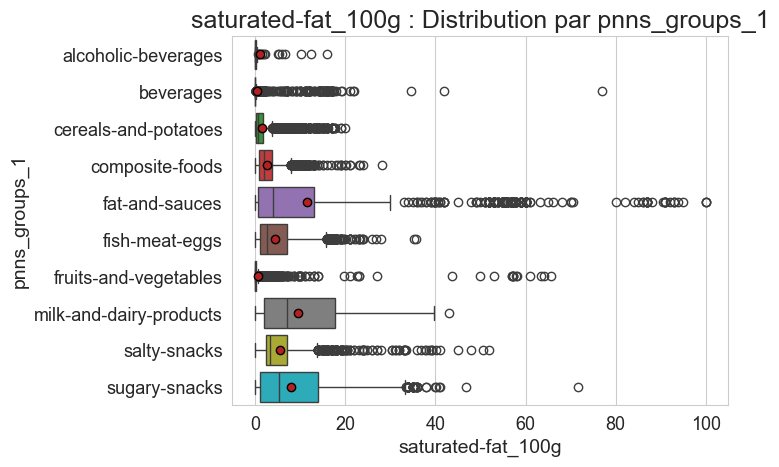

carbohydrates_100g                                   \
                                     count   mean    std  min     q1 median   
pnns_groups_1                                                                 
alcoholic-beverages                     63   9.29  11.36  0.1   2.50    3.3   
beverages                             4428  12.81  19.06  0.0   3.40    9.5   
cereals-and-potatoes                  5138  56.57  22.19  0.0  45.00   65.0   
composite-foods                       5252  15.78  11.71  0.0   7.30   13.7   
fat-and-sauces                        2771   7.32  10.17  0.0   0.60    4.5   
fish-meat-eggs                        4717   1.94   3.20  0.0   0.50    0.9   
fruits-and-vegetables                 3168  14.10  18.08  0.0   3.40    7.5   
milk-and-dairy-products               5098   9.19   9.98  0.0   1.00    4.8   
salty-snacks                          1784  44.53  20.41  0.0  32.98   51.0   
sugary-snacks                         7548  58.94  16.27  0.0  50.50   59.0   

                                       
                            q3    max  
pnns_groups_1                          
alcoholic-beverages       9.50   45.9  
beverages                11.30   99.0  
cereals-and-potatoes     72.18   91.2  
composite-foods          22.20   83.0  
fat-and-sauces            8.40   73.9  
fish-meat-eggs            2.00   37.0  
fruits-and-vegetables    15.00   93.0  
milk-and-dairy-products  14.80   95.0  
salty-snacks             59.00   83.6  
sugary-snacks            67.60  100.0

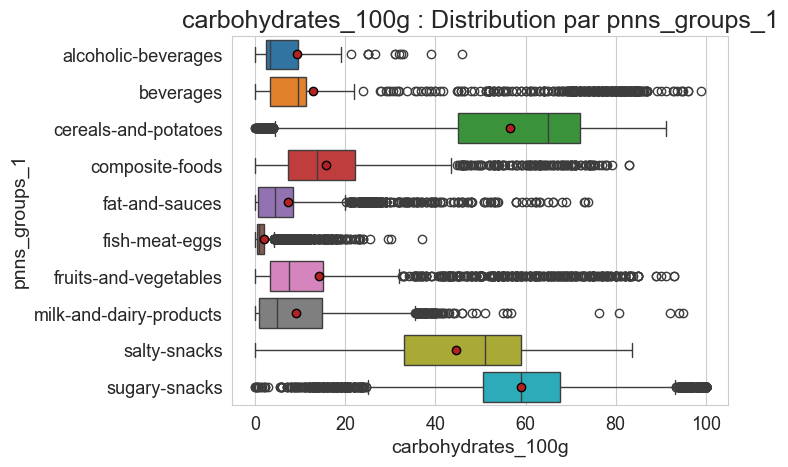

sugars_100g                                         \
                              count   mean    std  min    q1 median     q3   
pnns_groups_1                                                                
alcoholic-beverages              61   5.12   7.78  0.0   0.1   0.60   6.50   
beverages                      4915  11.68  17.45  0.0   3.5   9.00  11.00   
cereals-and-potatoes           5159   7.11   9.42  0.0   1.6   3.40   7.00   
composite-foods                5241   2.67   3.62  0.0   1.0   2.00   3.20   
fat-and-sauces                 2876   5.08   8.19  0.0   0.5   2.00   5.50   
fish-meat-eggs                 4648   0.88   1.08  0.0   0.3   0.60   1.00   
fruits-and-vegetables          3214  10.52  15.76  0.0   1.3   3.70  13.50   
milk-and-dairy-products        5128   7.81   8.29  0.0   0.5   4.60  13.20   
salty-snacks                   1836   4.72   6.47  0.0   1.5   3.20   5.70   
sugary-snacks                  9753  42.91  19.27  0.0  29.0  44.55  57.03   

                                
                           max  
pnns_groups_1                   
alcoholic-beverages       26.1  
beverages                 94.0  
cereals-and-potatoes      84.0  
composite-foods           44.5  
fat-and-sauces            66.0  
fish-meat-eggs            29.9  
fruits-and-vegetables     90.0  
milk-and-dairy-products   91.0  
salty-snacks              67.8  
sugary-snacks            100.0

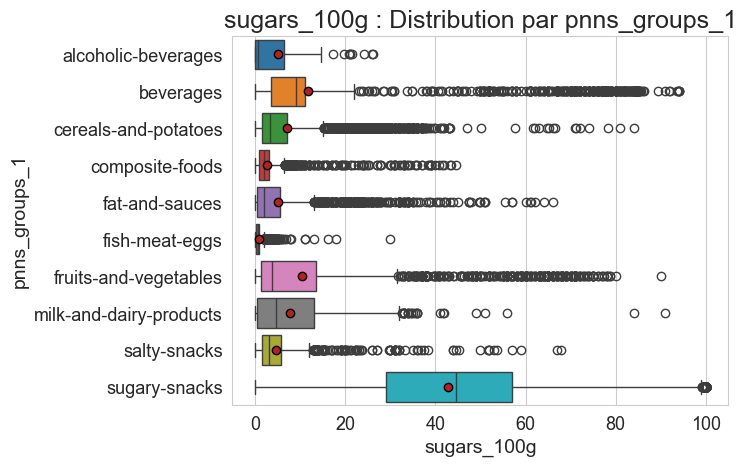

fiber_100g                                        
                             count  mean   std  min   q1 median   q3   max
pnns_groups_1                                                             
alcoholic-beverages             36  0.17  0.54  0.0  0.0    0.0  0.0   2.4
beverages                     3355  0.53  2.77  0.0  0.0    0.0  0.5  45.3
cereals-and-potatoes          4480  5.15  4.41  0.0  2.9    3.9  6.5  47.0
composite-foods               3572  2.10  1.78  0.0  1.0    1.7  2.6  23.0
fat-and-sauces                1673  0.95  1.36  0.0  0.0    0.3  1.6  14.4
fish-meat-eggs                1995  0.68  3.53  0.0  0.0    0.1  0.6  86.2
fruits-and-vegetables         2721  2.91  3.47  0.0  1.3    2.0  3.1  70.0
milk-and-dairy-products       2425  0.40  0.93  0.0  0.0    0.0  0.5  24.0
salty-snacks                  1290  4.57  2.89  0.0  2.8    4.1  5.5  21.0
sugary-snacks                 9753  2.76  3.04  0.0  1.5    1.9  3.2  54.0

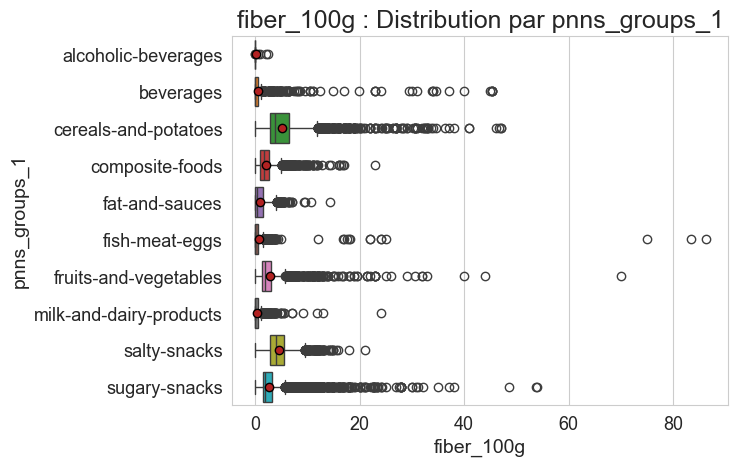

proteins_100g                                        \
                                count   mean   std  min     q1 median    q3   
pnns_groups_1                                                                 
alcoholic-beverages                82   0.87  1.41  0.0   0.05    0.4   0.6   
beverages                        5007   0.78  2.98  0.0   0.00    0.2   0.5   
cereals-and-potatoes             5375   9.90  4.42  0.0   7.40    9.4  12.0   
composite-foods                  5412   7.63  4.37  0.0   4.90    7.1  10.0   
fat-and-sauces                   2979   1.93  2.52  0.0   0.50    1.1   2.0   
fish-meat-eggs                   4944  18.73  6.26  0.0  14.20   19.3  22.0   
fruits-and-vegetables            3351   2.30  3.91  0.0   0.50    1.2   2.2   
milk-and-dairy-products          5396   9.91  8.92  0.0   3.20    4.6  18.0   
salty-snacks                     1866  10.22  6.92  0.0   5.80    7.1  13.0   
sugary-snacks                    9753   4.61  3.55  0.0   1.11    5.2   6.9   

                               
                          max  
pnns_groups_1                  
alcoholic-beverages       7.0  
beverages                86.0  
cereals-and-potatoes     50.5  
composite-foods          44.0  
fat-and-sauces           32.3  
fish-meat-eggs           53.0  
fruits-and-vegetables    34.0  
milk-and-dairy-products  49.0  
salty-snacks             58.8  
sugary-snacks            72.0

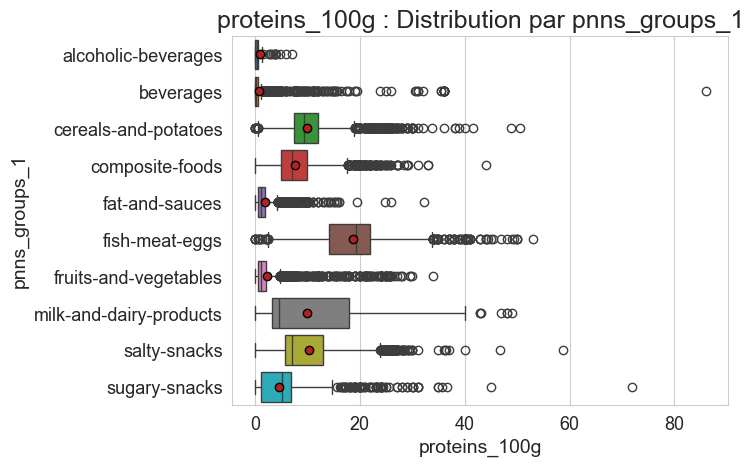

salt_100g                                            
                            count  mean   std  min    q1 median    q3     max
pnns_groups_1                                                                
alcoholic-beverages            62  0.66  3.29  0.0  0.00   0.02  0.10   22.86
beverages                    4566  0.11  1.52  0.0  0.00   0.01  0.03   76.20
cereals-and-potatoes         5136  0.60  0.73  0.0  0.02   0.40  1.02   12.50
composite-foods              5285  1.07  0.99  0.0  0.71   0.91  1.21   24.00
fat-and-sauces               2883  1.88  2.76  0.0  0.15   1.30  2.13   27.57
fish-meat-eggs               4704  2.03  1.69  0.0  1.05   1.78  2.50   29.47
fruits-and-vegetables        3200  0.47  1.07  0.0  0.01   0.13  0.70   32.80
milk-and-dairy-products      5162  0.68  0.80  0.0  0.10   0.16  1.30    6.30
salty-snacks                 1832  2.32  8.92  0.0  1.07   1.50  1.98  100.00
sugary-snacks                9753  0.34  0.82  0.0  0.08   0.15  0.53   71.12

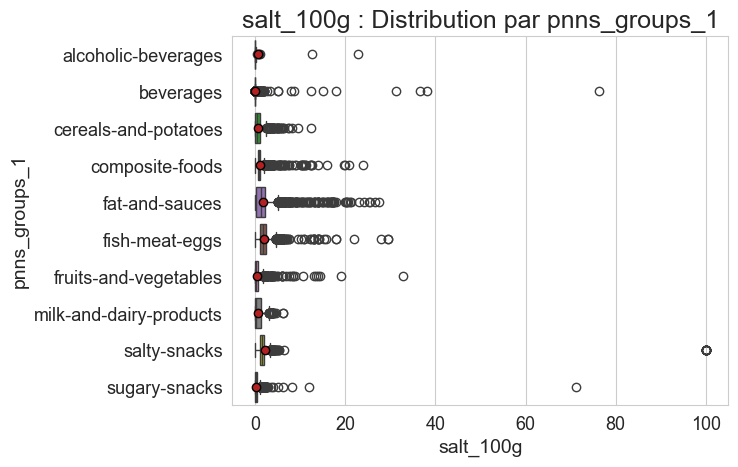

sodium_100g                                           
                              count  mean   std  min    q1 median    q3    max
pnns_groups_1                                                                 
alcoholic-beverages              62  0.26  1.29  0.0  0.00   0.01  0.04   9.00
beverages                      4566  0.05  0.60  0.0  0.00   0.00  0.01  30.00
cereals-and-potatoes           5136  0.24  0.29  0.0  0.01   0.16  0.40   4.92
composite-foods                5285  0.42  0.39  0.0  0.28   0.36  0.48   9.45
fat-and-sauces                 2883  0.74  1.08  0.0  0.06   0.51  0.84  10.85
fish-meat-eggs                 4703  0.80  0.67  0.0  0.41   0.70  0.98  11.60
fruits-and-vegetables          3199  0.18  0.42  0.0  0.00   0.05  0.28  12.91
milk-and-dairy-products        5162  0.27  0.32  0.0  0.04   0.06  0.51   2.48
salty-snacks                   1832  0.91  3.51  0.0  0.42   0.59  0.78  39.37
sugary-snacks                  7683  0.16  0.36  0.0  0.02   0.10  0.25  28.00

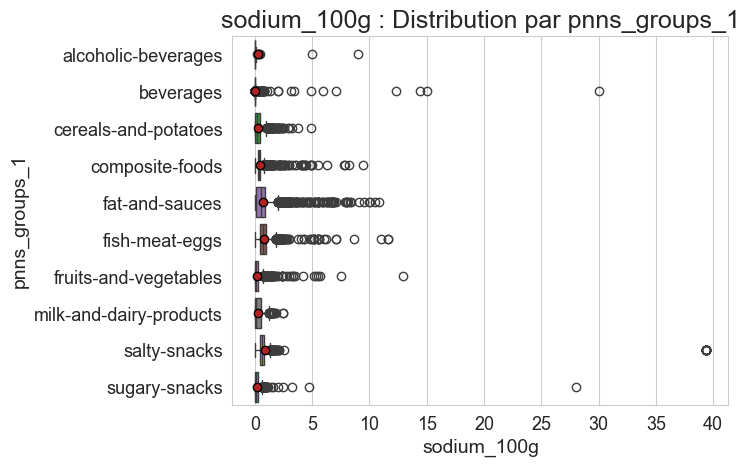

fruits-vegetables-nuts_100g                           \
                                              count   mean    std  min    q1   
pnns_groups_1                                                                  
alcoholic-beverages                               0    NaN    NaN  NaN   NaN   
beverages                                       999  19.99  31.22  0.0   0.0   
cereals-and-potatoes                             60  18.57  33.94  0.0   0.0   
composite-foods                                 365  36.78  25.68  0.0  16.0   
fat-and-sauces                                  315   2.27  12.81  0.0   0.0   
fish-meat-eggs                                   31   8.82  16.28  0.0   0.0   
fruits-and-vegetables                           321  70.13  27.95  0.0  43.0   
milk-and-dairy-products                         265   7.68   6.28  0.0   4.0   
salty-snacks                                     32  30.41  44.17  0.0   0.0   
sugary-snacks                                  9753  18.31  19.84  0.0   0.0   

                                              
                        median     q3    max  
pnns_groups_1                                 
alcoholic-beverages        NaN    NaN    NaN  
beverages                  0.0  35.00  100.0  
cereals-and-potatoes       1.0  16.95  100.0  
composite-foods           30.9  52.60  100.0  
fat-and-sauces             0.0   0.00  100.0  
fish-meat-eggs             0.0  10.50   55.0  
fruits-and-vegetables     80.0  99.70  100.0  
milk-and-dairy-products    8.8  10.00   60.0  
salty-snacks               0.0  81.25  100.0  
sugary-snacks             13.5  35.82  100.0

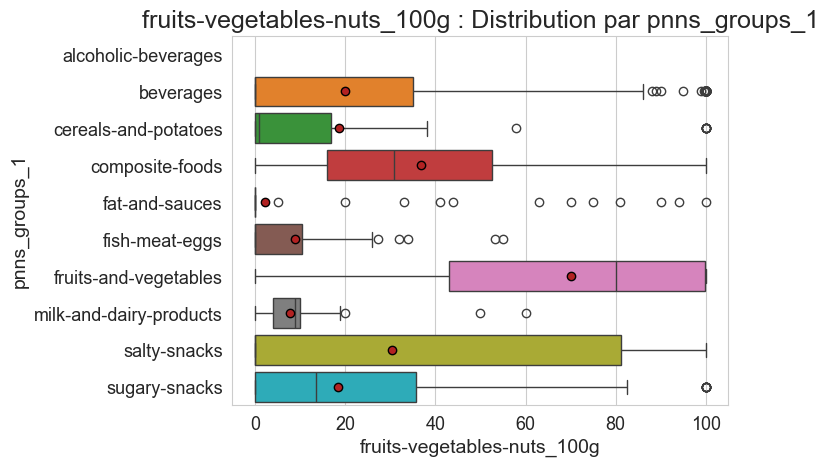

nutrition-score-fr_100g                            \
                                          count   mean   std   min     q1   
pnns_groups_1                                                               
alcoholic-beverages                          58   8.90  4.42   0.0   6.00   
beverages                                  4393   8.14  6.77  -8.0   3.00   
cereals-and-potatoes                       5092   1.27  6.81 -12.0  -5.00   
composite-foods                            5080   3.61  5.92 -13.0   0.00   
fat-and-sauces                             2795  12.32  6.88  -8.0   8.00   
fish-meat-eggs                             4621   9.55  8.32  -6.0   3.00   
fruits-and-vegetables                      3096  -2.87  4.69 -15.0  -6.00   
milk-and-dairy-products                    5085   8.57  6.63  -6.0   2.00   
salty-snacks                               1814  13.06  5.99  -9.0   9.00   
sugary-snacks                              9753  16.21  6.56  -6.0  10.64   

                                             
                        median     q3   max  
pnns_groups_1                                
alcoholic-beverages        8.0  10.75  26.0  
beverages                  7.0  13.00  40.0  
cereals-and-potatoes      -1.0   6.00  35.0  
composite-foods            2.0   6.00  26.0  
fat-and-sauces            12.0  17.50  30.0  
fish-meat-eggs            10.0  17.00  27.0  
fruits-and-vegetables     -4.0   0.00  19.0  
milk-and-dairy-products   10.0  14.00  30.0  
salty-snacks              13.0  16.00  32.0  
sugary-snacks             15.0  22.00  33.0

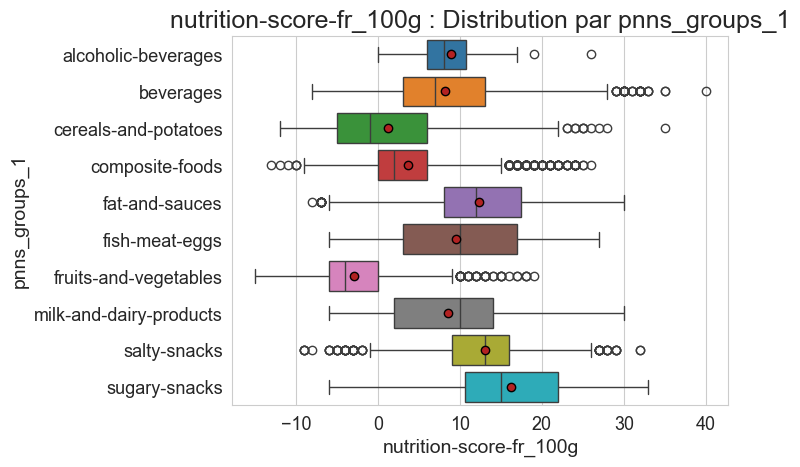

In [26]:
colors_groups = sns.color_palette('tab10')

stats(frfoodfacts_df, nutri_features, 'pnns_groups_1', colors_groups, True)

### Matrice des corrélations

Nous avons pu observé en partie 2 que certaines variables étaient corrélées et nous retrouvons bien ici ces liens pour :
- `salt_100g`et `sodium_100g`
- `nutrition-score-fr_100g` et `energy_100g`, `saturated-fat_100g`, `sugars_100g`, `fruits-vegetables-nuts_100g`
- `fat_100g` et `saturated-fat_100g`
- `carbohydrates_100g` et `sugars_100g`

Nous observons en plus une corrélation forte entre `energy_100g` et `fat_100g`.

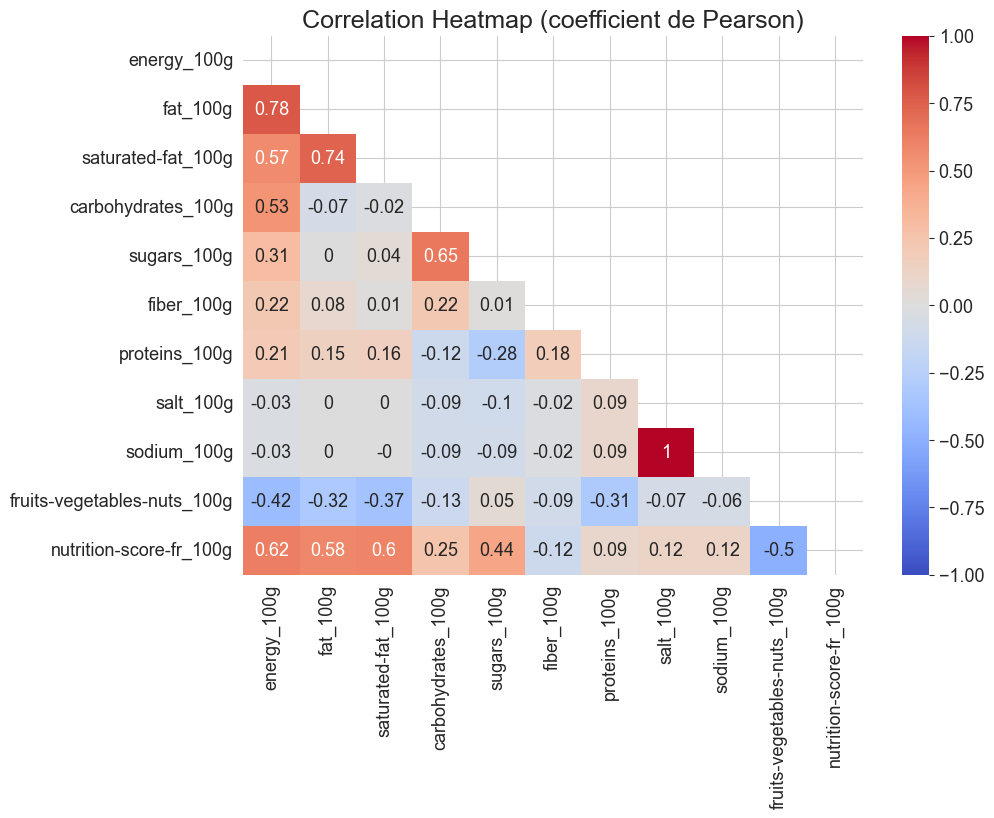

In [27]:
# Calcul du coefficient de corrélation de Pearson et représentation sous forme de heatmap
plt.figure(figsize=(10,7))
corr = round(frfoodfacts_df[nutri_features].corr(method='pearson'),2)
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, 
                      vmin=-1, 
                      vmax=1, 
                      annot=True, 
                      cmap='coolwarm', 
                      mask=mask)
heatmap.set_title('Correlation Heatmap (coefficient de Pearson)')
plt.show()

### Relation entre `energy_100g` et `fat_100g`

#### Pairplot energy_100g, fat_100g et saturated-fat
Analysons les représentations des pairplots entre les variables `energy_100g`, `fat_100g` et `saturated-fat_100g`. 

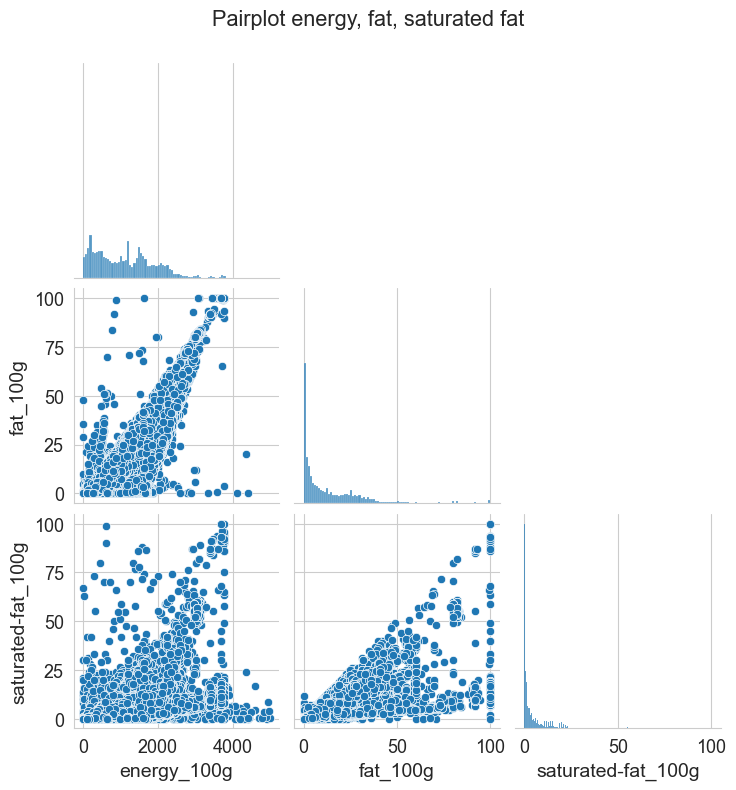

In [28]:
# Pairplot energy_100g, fat_100g et saturated-fat
data = [
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g'
]
sns.pairplot(data=frfoodfacts_df[data], 
             dropna = True,
             corner = True).fig.suptitle('Pairplot energy, fat, saturated fat', y=1.05)
plt.show()

Une relation linaire semble présente entre `energy_100g` et `fat_100g` : cette observation est à vérifier à l'aide d'un test statistique.

#### Test statistique sur le lien entre `energy_100g` et `fat_100g`

Test de normalité de la distribution de energy_100g


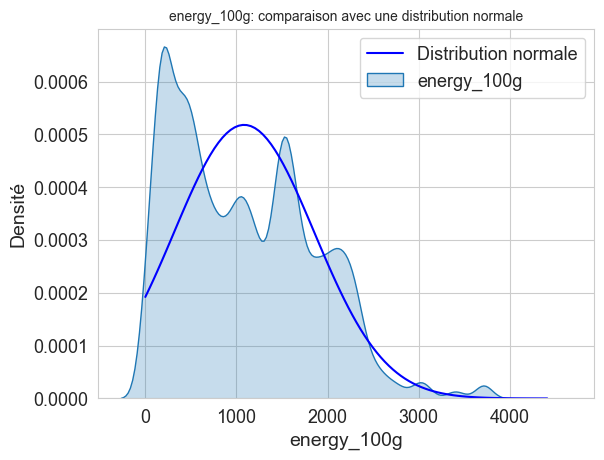

Test de Kolmogorov-Smirnov : stat = 0.982 , p=0.000 

p-value < 0.05, H0 peut être rejetée : la distribution ne suit pas la loi normale.
----------------------------------------------------------------------------------------------------
Test de normalité de la distribution de fat_100g


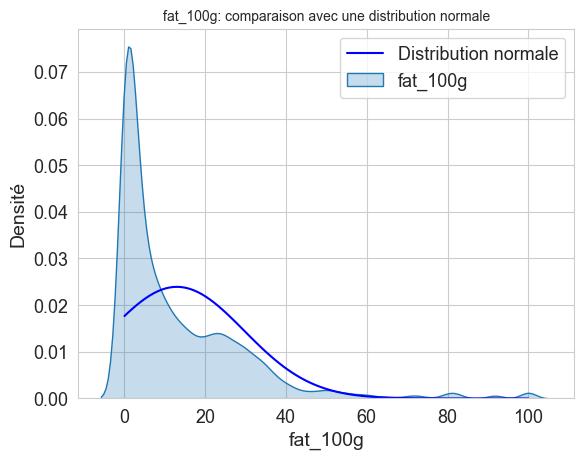

Test de Kolmogorov-Smirnov : stat = 0.672 , p=0.000 

p-value < 0.05, H0 peut être rejetée : la distribution ne suit pas la loi normale.
----------------------------------------------------------------------------------------------------
Coefficient de rang de Spearman
Le coefficient de corrélation de Pearson est égal à : 0.76
p-value=0.0
p-value < 0.05, H0 est rejetée: il existe une relation linéaire significative entre les variables energy_100g et fat_100g.
Les 2 variables ont une forte corrélation positive.


In [29]:
# Test statistique de corrélation linéaire
correlation_test(frfoodfacts_df, 'energy_100g', 'fat_100g')

### Relation entre `pnns_groups_1` et `nutrition_grade_fr`

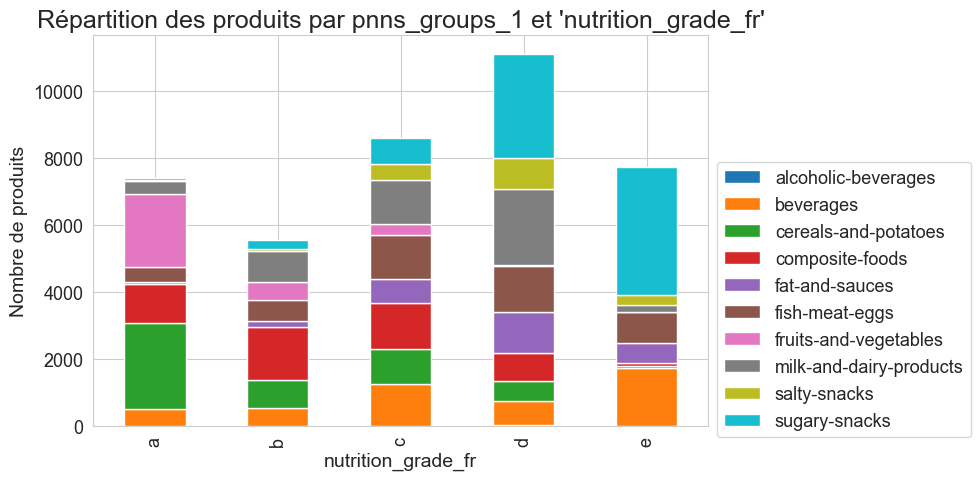

In [30]:
# Répartition des produits par pnns_groups_1 et 'nutrition_grade_fr'
fig, ax = plt.subplots(1,1,figsize=(10,5))

frfoodfacts_df.pivot_table(index=['nutrition_grade_fr'], columns='pnns_groups_1', values = 'code', aggfunc='count')\
        .plot(ax=ax, kind='bar', 
              title="Répartition des produits par pnns_groups_1 et 'nutrition_grade_fr'", 
              stacked=True, 
              color=colors_groups)
ax.legend(bbox_to_anchor=(1, 0.7, 0, 0))
ax.set_ylabel('Nombre de produits')

plt.tight_layout()
plt.show()

#### Tableau des contingences

In [31]:
test = frfoodfacts_df[~frfoodfacts_df['pnns_groups_1'].isna()]

# Tableau des contingences
X = "pnns_groups_1"
Y = "nutrition_grade_fr"

cont = test[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
display(cont)

nutrition_grade_fr            a       b       c        d       e  Total
pnns_groups_1                                                          
alcoholic-beverages         NaN     3.0     7.0     34.0    14.0     58
beverages                 513.0   553.0  1254.0    716.0  1715.0   4751
cereals-and-potatoes     2565.0   820.0  1035.0    610.0    62.0   5092
composite-foods          1172.0  1592.0  1400.0    827.0    89.0   5080
fat-and-sauces             71.0   184.0   706.0   1232.0   602.0   2795
fish-meat-eggs            427.0   606.0  1304.0   1363.0   921.0   4621
fruits-and-vegetables    2197.0   550.0   319.0     29.0     1.0   3096
milk-and-dairy-products   370.0   922.0  1313.0   2262.0   218.0   5085
salty-snacks               39.0    62.0   491.0    919.0   303.0   1814
sugary-snacks              51.0   261.0   766.0   3115.0  3812.0   8005
Total                    7405.0  5553.0  8595.0  11107.0  7737.0  40397

**Condition d'application du test d'indépendance du chi-2 :** 
- 2 variables qualitatives, collectées de manière indépendantes
- aucune valeur attendue n'est égale à 0
- pour 80% des combinaisons des 2 variables, les valeurs observées et attendues sont supérieures à 5.

Les effectifs (valeurs observées) sont insuffisants pour 'alcoholic beverages' et 'fruits-and-vegetables' : certaines valeurs sont < 5.
Aggrégons 'alcoholic beverages' avec 'beverages' et 'fruits-and-vegetables' avec 'cereals-and-potatoes'.

In [32]:
# Aggrégation de 'alcoholic beverages' avec 'beverages' et 'fruits-and-vegetables' avec 'cereals-and-potatoes'
test.loc[test['pnns_groups_1'].isin(['beverages','alcoholic-beverages']),
         'pnns_groups_1'] = 'beverages-alcoholic-beverages'
test.loc[test['pnns_groups_1'].isin(['fruits-and-vegetables','cereals-and-potatoes']),
         'pnns_groups_1'] = 'fruits-and-vegetables-cereals-and-potatoes'

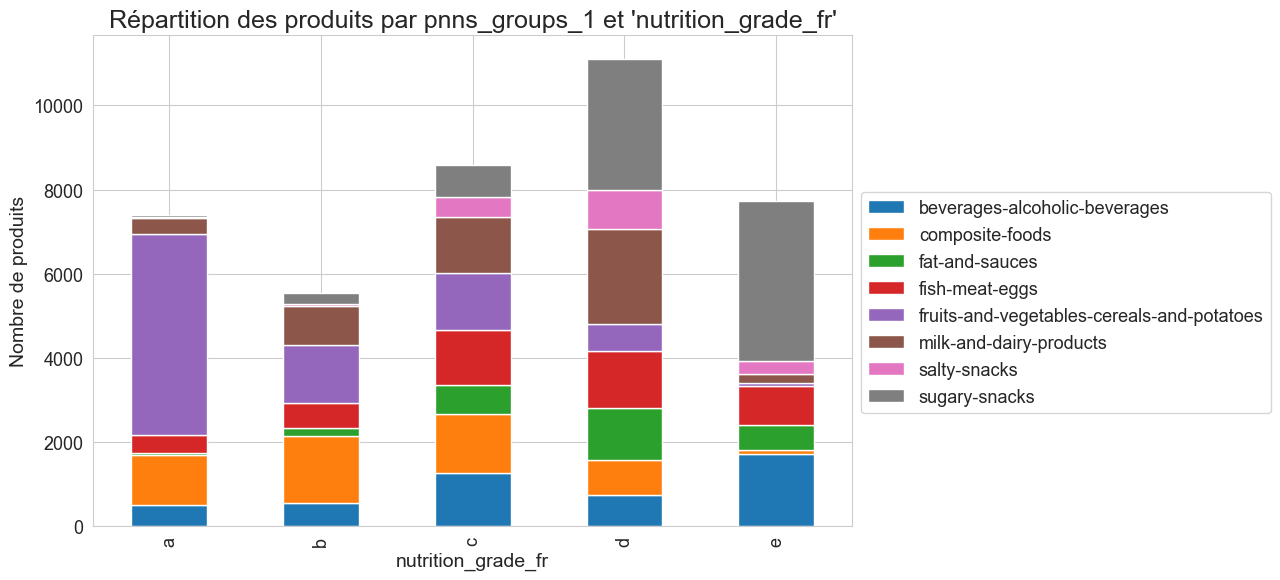

In [33]:
# Répartition des produits par pnns_groups_1 et 'nutrition_grade_fr'
fig, ax = plt.subplots(1,1,figsize=(13,6))

test.pivot_table(index=['nutrition_grade_fr'], columns='pnns_groups_1', values = 'code', aggfunc='count')\
        .plot(ax=ax, kind='bar', 
              title="Répartition des produits par pnns_groups_1 et 'nutrition_grade_fr'", 
              stacked=True, 
              color=colors_groups)
ax.legend(bbox_to_anchor=(1, 0.7, 0, 0))
ax.set_ylabel('Nombre de produits')

plt.tight_layout()
plt.show()

In [34]:
# Tableau des contingences
cont = test[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
display(cont)

nutrition_grade_fr                             a     b     c      d     e  \
pnns_groups_1                                                               
beverages-alcoholic-beverages                513   556  1261    750  1729   
composite-foods                             1172  1592  1400    827    89   
fat-and-sauces                                71   184   706   1232   602   
fish-meat-eggs                               427   606  1304   1363   921   
fruits-and-vegetables-cereals-and-potatoes  4762  1370  1354    639    63   
milk-and-dairy-products                      370   922  1313   2262   218   
salty-snacks                                  39    62   491    919   303   
sugary-snacks                                 51   261   766   3115  3812   
Total                                       7405  5553  8595  11107  7737   

nutrition_grade_fr                          Total  
pnns_groups_1                                      
beverages-alcoholic-beverages                4809  
composite-foods                              5080  
fat-and-sauces                               2795  
fish-meat-eggs                               4621  
fruits-and-vegetables-cereals-and-potatoes   8188  
milk-and-dairy-products                      5085  
salty-snacks                                 1814  
sugary-snacks                                8005  
Total                                       40397

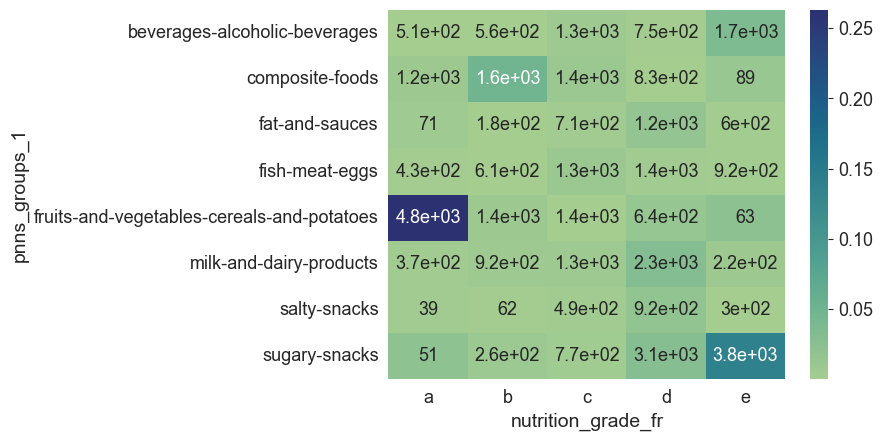

In [35]:
# Calcul des écarts au carré normalisés
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(test)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

# Affichage des résultats sous forme de heatmap
sns.heatmap(table.iloc[:-1,:-1], annot=c.iloc[:-1,:-1], cmap="crest")
plt.show()

Certains groupes de nutriments ont plus fréquemment des nutrition_grade_fr faibles ou forts.

#### Test d'indépendance du Chi2

In [36]:
# Test d'indépendance du Chi2
chi2_test(test, 'pnns_groups_1', 'nutrition_grade_fr')

Résultats du test d'intépendance du Chi-2 et du test de Cramer pour l'intensité de la relation
--------------------------------------------------
Le degré de liberté est de 28
Chi-2 = 23116.61
pvalue = 0.0
V de Cramer = 0.38

pvalue < 0.05, H0 est rejetée: les variables pnns_groups_1 et nutrition_grade_fr ne sont pas indépendantes.
L'intensité de la relation est forte.
Toutes les valeurs attendues sont > 5.


### Relation entre `nutrition-score-fr_100g` et `nutrition_grade_fr`

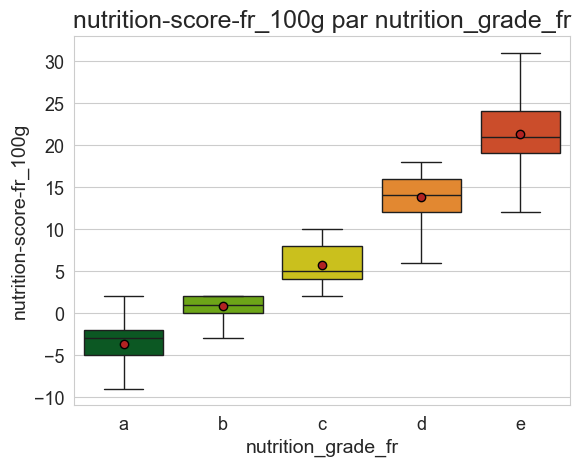

In [37]:
sns.boxplot(data=frfoodfacts_df.sort_values('nutrition_grade_fr'), 
            x='nutrition_grade_fr', 
            y='nutrition-score-fr_100g', 
            hue='nutrition_grade_fr',
            palette = ['#00641E', '#72BC00', '#E7DA00', '#FF8714', '#E63E10'],
            showfliers=False, 
            showmeans=True, 
            meanprops=meanprops,
            legend=False)

plt.title("nutrition-score-fr_100g par nutrition_grade_fr")
plt.show()

#### Test statistique type ANOVA

Test de normalité


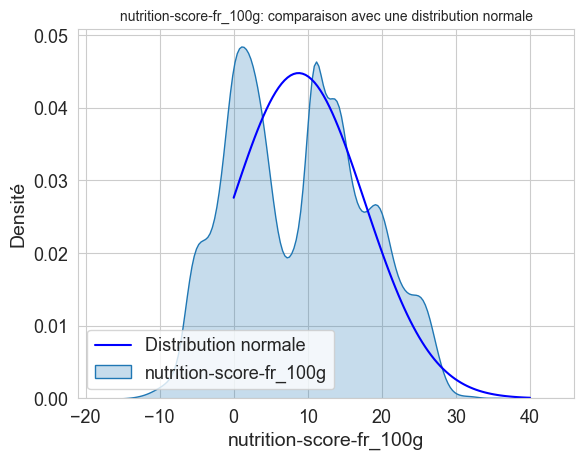

Test de Kolmogorov-Smirnov : stat = 0.716 , p=0.000 

p-value < 0.05, H0 peut être rejetée : la distribution ne suit pas la loi normale.
----------------------------------------------------------------------------------------------------
Test d'égalité des variances
Variable : nutrition-score-fr_100g
Variance = 79.361


W  pval  equal_var
levene  2380.635   0.0      False

H0 peut être rejetée : les variances de la variable nutrition-score-fr_100g pour les groupes nutrition_grade_fr ne sont pas égales
----------------------------------------------------------------------------------------------------
Test Kruskal-Wallis


Source  ddof1          H  p-unc
Kruskal  nutrition_grade_fr      4  56755.527    0.0

p-value < 0.05, H0 peut être rejetée : les médianes de la variable nutrition-score-fr_100g pour les groupes nutrition_grade_fr ne sont pas égales


Post-hoc Pairwise_tests


Contrast  A  B  Paired  Parametric       U-val alternative  \
0  nutrition_grade_fr  a  b   False       False    661830.5   two-sided   
1  nutrition_grade_fr  a  c   False       False     24945.5   two-sided   
2  nutrition_grade_fr  a  d   False       False       814.5   two-sided   
3  nutrition_grade_fr  a  e   False       False        91.0   two-sided   
4  nutrition_grade_fr  b  c   False       False    527630.0   two-sided   
5  nutrition_grade_fr  b  d   False       False         0.0   two-sided   
6  nutrition_grade_fr  b  e   False       False         0.0   two-sided   
7  nutrition_grade_fr  c  d   False       False   2588183.0   two-sided   
8  nutrition_grade_fr  c  e   False       False    125853.0   two-sided   
9  nutrition_grade_fr  d  e   False       False  12571117.5   two-sided   

   p-unc  hedges  
0    0.0  -2.522  
1    0.0  -3.883  
2    0.0  -7.094  
3    0.0  -7.520  
4    0.0  -2.405  
5    0.0  -6.070  
6    0.0  -6.683  
7    0.0  -3.235  
8    0.0  -4.786  
9    0.0  -2.355

In [38]:
anova_test(frfoodfacts_df, 'nutrition-score-fr_100g', 'nutrition_grade_fr')

### Relation entre `energie_100g` et `nutrition_grade_fr`

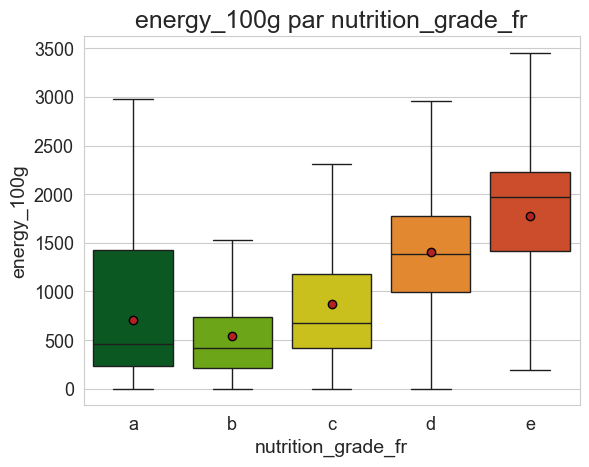

In [39]:
sns.boxplot(data=frfoodfacts_df.sort_values('nutrition_grade_fr'), 
            x='nutrition_grade_fr', 
            y='energy_100g', 
            hue='nutrition_grade_fr',
            palette = ['#00641E', '#72BC00', '#E7DA00', '#FF8714', '#E63E10'],
            showfliers=False, 
            showmeans=True, 
            meanprops=meanprops,
            legend=False)

plt.title("energy_100g par nutrition_grade_fr")
plt.show()

#### Test statistique type ANOVA

Test de normalité


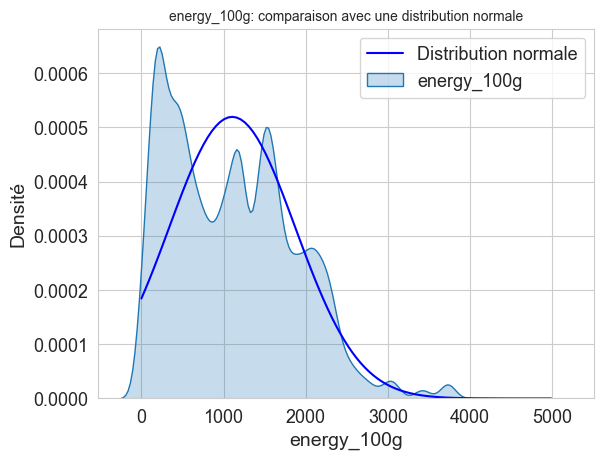

Test de Kolmogorov-Smirnov : stat = 0.985 , p=0.000 

p-value < 0.05, H0 peut être rejetée : la distribution ne suit pas la loi normale.
----------------------------------------------------------------------------------------------------
Test d'égalité des variances
Variable : energy_100g
Variance = 589876.994


W  pval  equal_var
levene  364.968   0.0      False

H0 peut être rejetée : les variances de la variable energy_100g pour les groupes nutrition_grade_fr ne sont pas égales
----------------------------------------------------------------------------------------------------
Test Kruskal-Wallis


Source  ddof1         H  p-unc
Kruskal  nutrition_grade_fr      4  20108.59    0.0

p-value < 0.05, H0 peut être rejetée : les médianes de la variable energy_100g pour les groupes nutrition_grade_fr ne sont pas égales


Post-hoc Pairwise_tests


Contrast  A  B  Paired  Parametric       U-val alternative  \
0  nutrition_grade_fr  a  b   False       False  52133608.0   two-sided   
1  nutrition_grade_fr  a  c   False       False  55550286.5   two-sided   
2  nutrition_grade_fr  a  d   False       False  38539896.5   two-sided   
3  nutrition_grade_fr  a  e   False       False  17715443.5   two-sided   
4  nutrition_grade_fr  b  c   False       False  40200035.5   two-sided   
5  nutrition_grade_fr  b  d   False       False  20521829.0   two-sided   
6  nutrition_grade_fr  b  e   False       False  12279822.0   two-sided   
7  nutrition_grade_fr  c  d   False       False  57273119.0   two-sided   
8  nutrition_grade_fr  c  e   False       False  29393713.5   two-sided   
9  nutrition_grade_fr  d  e   False       False  61956706.0   two-sided   

   p-unc  hedges  
0    0.0   0.304  
1    0.0  -0.261  
2    0.0  -1.116  
3    0.0  -1.578  
4    0.0  -0.553  
5    0.0  -1.445  
6    0.0  -1.908  
7    0.0  -0.823  
8    0.0  -1.293  
9    0.0  -0.532

In [40]:
anova_test(frfoodfacts_df, 'energy_100g', 'nutrition_grade_fr')

Toutes les médianes des groupes comparés 2 à 2 ne sont pas égales (toutes les p-values sont < 0.05).

## <font color='#46abe6'>3.3. Analyse multivariée : Analyse en Composantes Principales<a class="anchor" id="3_3"></a></font>

Pour l'analyse en composantes principales (ACP):
- sélectionnons les variables pertinentes (éviter les variables fortement corrélées),
- supprimons les lignes contenant des valeurs manquantes, 
- conservons les variables numériques uniquement, 
- plaçons 'code' en index.

In [41]:
# Sélection des variables
acp_features = [ 'code',
                 'product_name',
                 'pnns_groups_1', 
                 'pnns_groups_2',
                 'nutrition_grade_fr',
                 'energy_100g',
                 'saturated-fat_100g',
                 'sugars_100g',
                 'fiber_100g',
                 'proteins_100g',
                 'salt_100g',
                 'fruits-vegetables-nuts_100g',
                 'nutrition-score-fr_100g']

In [42]:
# Suppression des lignes contenant des valeurs nulles
frfoodfacts_df_acp = frfoodfacts_df[acp_features].dropna().sort_values('nutrition_grade_fr')

# Mettre de côté les variables catégorielles
df_acp = frfoodfacts_df_acp.drop(columns = ['product_name','pnns_groups_1','pnns_groups_2', 'nutrition_grade_fr'])

In [43]:
# Mettre la colonne 'code' en index
df_acp = df_acp.set_index('code')

In [44]:
# Dimensions du dataframe
df_acp.shape

(9314, 8)

### 3.3.1. Détermination du nombre de composantes

#### Séparation des données

In [45]:
# Matrice des données 
X = df_acp.values

# Vérifier la dimension
display(X.shape)

names = df_acp.index # Noms des individus
features = df_acp.columns # Noms des variables
p = df_acp.shape[1] # nb de variables

(9314, 8)

#### Scaling (centrage-reduction)

In [46]:
# Instanciation
scaler = StandardScaler()

# Fit and transform
X_scaled = scaler.fit_transform(X)

# Visualisation de la moyenne et de l'écart-type : attendu moy = 0 et std =1
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6    7
mean  0.0 -0.0  0.0  0.0 -0.0  0.0 -0.0 -0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

#### ACP

In [47]:
# Instanciation de l'ACP
pca_all = PCA()

# Entraînement sur les données scalées
pca_all.fit(X_scaled)

PCA()

#### Valeurs propres

Les 3 premières composantes permettent d'expliquer 70% de la variance.

In [48]:
scree = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(p)], 
        "Variance expliquée" : pca_all.explained_variance_,
        "% variance expliquée" : np.round(pca_all.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca_all.explained_variance_ratio_) * 100)
    }
)
scree

Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Dim1            3.140257                  39.0                   39.0
1      Dim2            1.443025                  18.0                   57.0
2      Dim3            1.035485                  13.0                   70.0
3      Dim4            0.778598                  10.0                   80.0
4      Dim5            0.672797                   8.0                   88.0
5      Dim6            0.500543                   6.0                   95.0
6      Dim7            0.266530                   3.0                   98.0
7      Dim8            0.163623                   2.0                  100.0

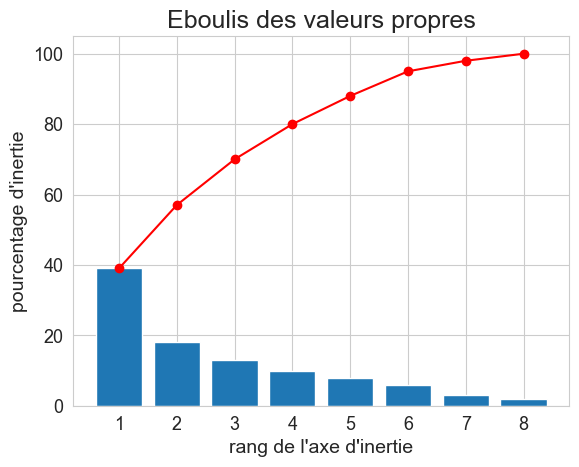

In [49]:
# liste des composants (indice des composantes)
x_list = range(1, p+1)
list(x_list)

# Représentation graphiques des valeurs propres
plt.bar(x_list, scree['% variance expliquée'])
plt.plot(x_list, scree['% cum. var. expliquée'],c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

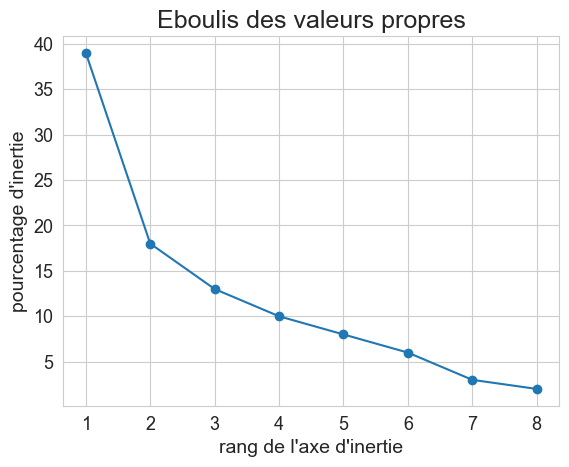

In [50]:
# Représentation graphiques des valeurs propres - méthode du coude
plt.plot(x_list, scree['% variance expliquée'],marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Selon la méthode du coude, le nombre de composantes retenu est 3 ou 4.

### 3.3.2. Composantes principales

In [51]:
# Nombre de composantes principales 
n_components = 4

# Instanciation de l'ACP
pca = PCA(n_components=n_components)

# Entraînement sur les données scalées
pca.fit(X_scaled)

PCA(n_components=4)

In [52]:
# Principal Components = PCs
pcs = pd.DataFrame(pca.components_)

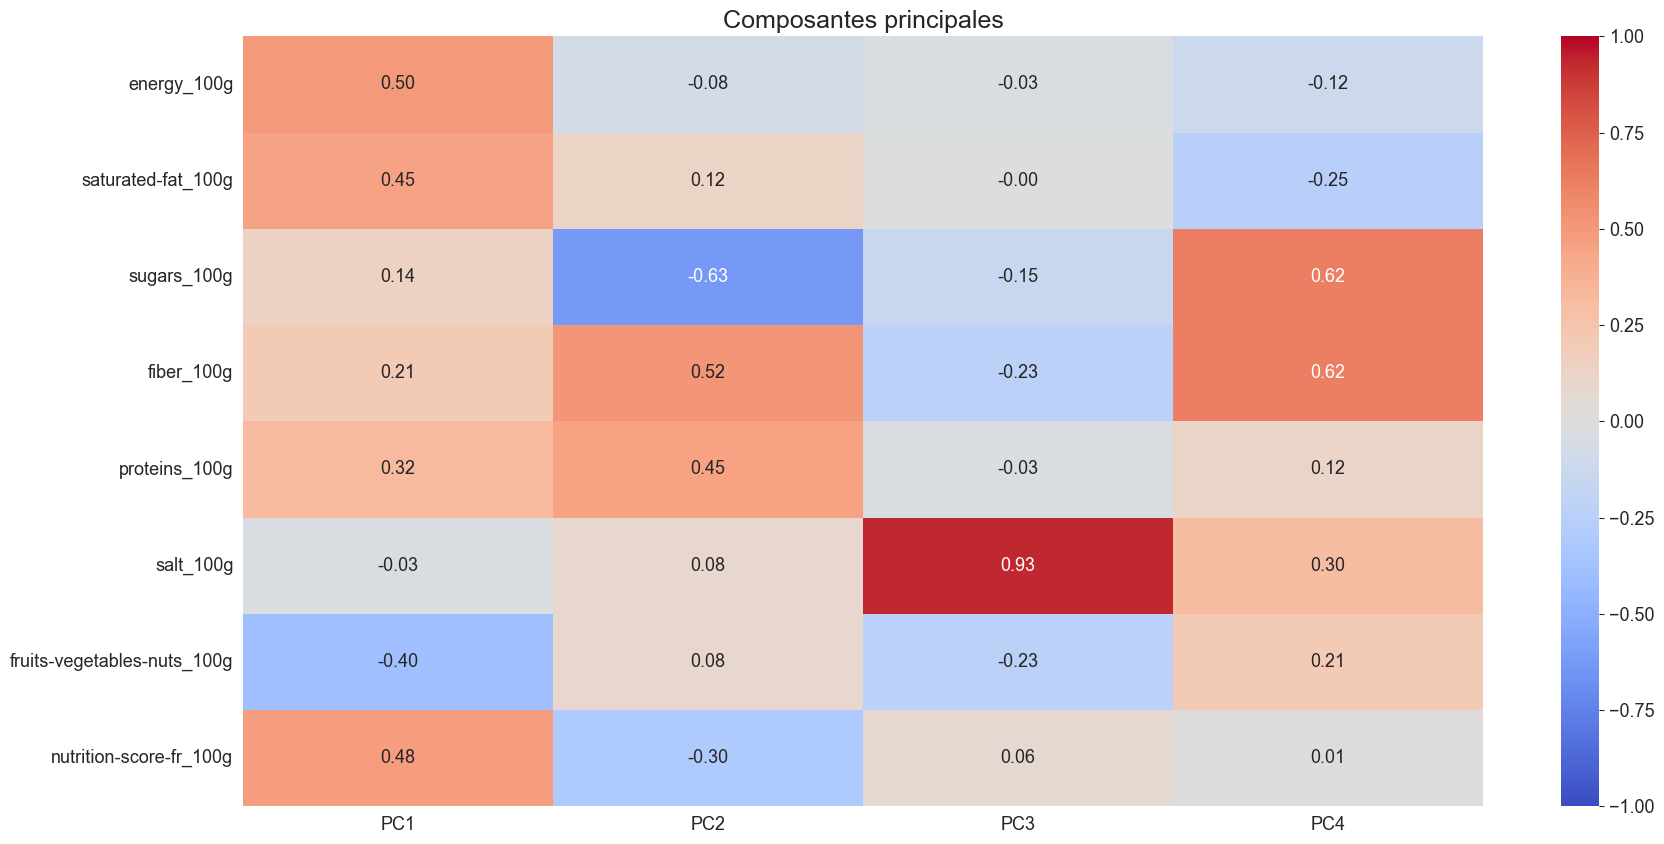

In [53]:
# affichage de 'features' pour les colonnes et Fi en index
pcs.columns = features

# liste des composants (indice des composantes)
x_list = range(1, n_components+1)
list(x_list)

pcs.index = [f"PC{i}" for i in x_list]
pcs.round(2)

# Représentation sous forme de heatmap des 3 premières composantes
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(pcs.T.iloc[:,:5], vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title('Composantes principales')
plt.show()

### Représentation graphique de l'ACP

#### Graphe des corrélations

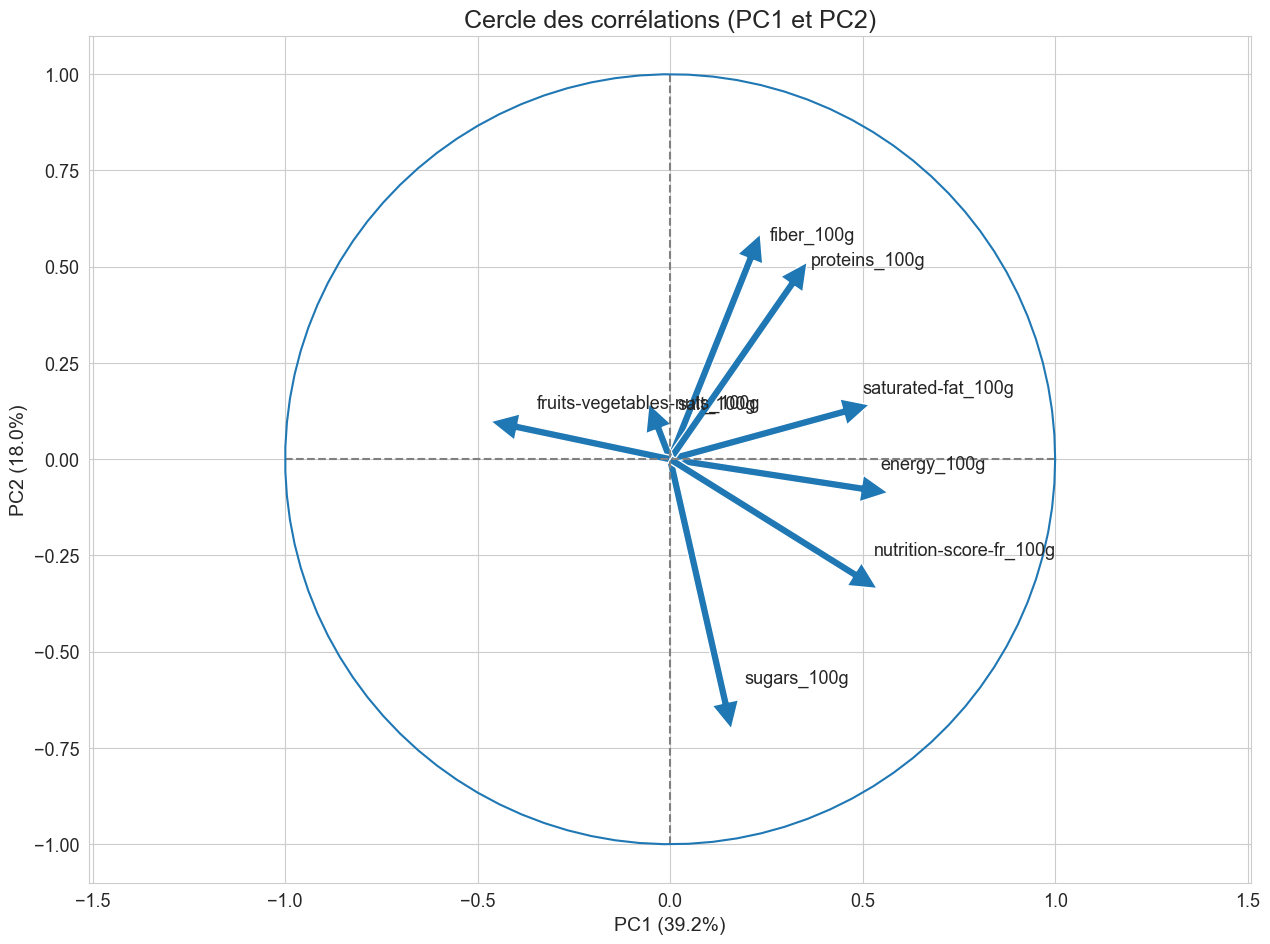

In [54]:
# Graphe de corrélation pour PC1 et PC2 - Premier plan factoriel
correlation_graph(pca, (0,1), features)

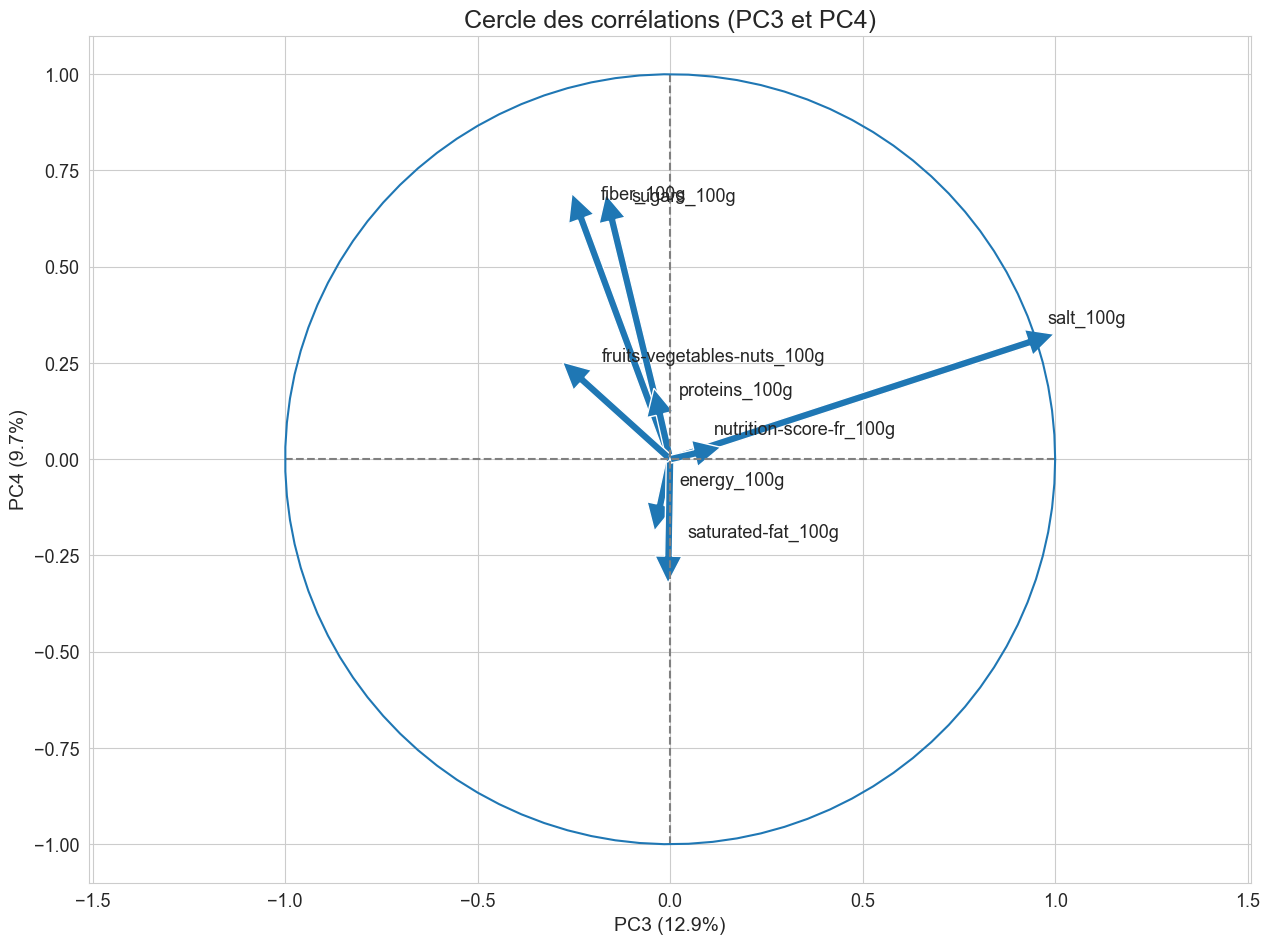

In [55]:
# Graphe de corrélation pour PC3 et PC4 - Premier plan factoriel
correlation_graph(pca, (2,3), features)

##### Qualité de représentation des variables sur les composantes principales

* Qualité de représentation de chaque variable = coefficients cosinus² = (coordonnées des variables)² 
* Les variables les mieux représentées : taux de représentation supérieur à la moyenne sur chaque composante

In [56]:
n = df_acp.shape[0] # nb individus
p = df_acp.shape[1] # nb de variables
pc = n_components # nb de composantes

eigval = (n-1) / n * pca.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres

corvar = np.zeros((p,pc)) # matrice vide pour avoir les coordonnées

for k in range(pc):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

In [57]:
#cosinus carré des variables
cos2var = corvar**2

COS = [] # création liste vide
for k in range(1,pc+1): # boucle pour créer la liste de noms des colonnes (COS2_1, ...)
    COS_num = "COS2_"+str(k)
    COS.append(COS_num)

# Dataframe avec les coefficients cos² des variables pour toutes les composantes principales   
df_ctr_variables = pd.DataFrame(cos2var, columns = COS, index = features)

In [58]:
df_ctr_variables

COS2_1    COS2_2    COS2_3    COS2_4
energy_100g                  0.773984  0.008362  0.000689  0.010854
saturated-fat_100g           0.635736  0.021789  0.000019  0.049387
sugars_100g                  0.064528  0.577141  0.023501  0.299418
fiber_100g                   0.135937  0.390155  0.055178  0.303729
proteins_100g                0.313119  0.297645  0.000731  0.010499
salt_100g                    0.002855  0.008975  0.897409  0.071623
fruits-vegetables-nuts_100g  0.495376  0.010090  0.053660  0.032833
nutrition-score-fr_100g      0.718386  0.128714  0.004186  0.000173

In [59]:
# Variables contribuant à la première composante
for i, cos2 in enumerate(COS):
    print(f'Contributions de PC{i+1}')
    display(
        list(df_ctr_variables[df_ctr_variables[cos2] > df_ctr_variables[cos2].mean()]\
            .sort_values(cos2, ascending = False)\
            .index)
           )

Contributions de PC1


['energy_100g',
 'nutrition-score-fr_100g',
 'saturated-fat_100g',
 'fruits-vegetables-nuts_100g']

Contributions de PC2


['sugars_100g', 'fiber_100g', 'proteins_100g']

Contributions de PC3


['salt_100g']

Contributions de PC4


['fiber_100g', 'sugars_100g']

##### Interprétation des composantes
| PC  | Variables les mieux représentées|
|:---:|:---------------------------------------------------------------------------------------|
| PC1 | 'energy_100g', 'nutrition-score-fr_100g'|
| PC2 | 'sugars_100g'                  |
| PC3 | 'salt_100g'                                 |

#### Projection des individus

In [60]:
X_proj = pca.transform(X_scaled)

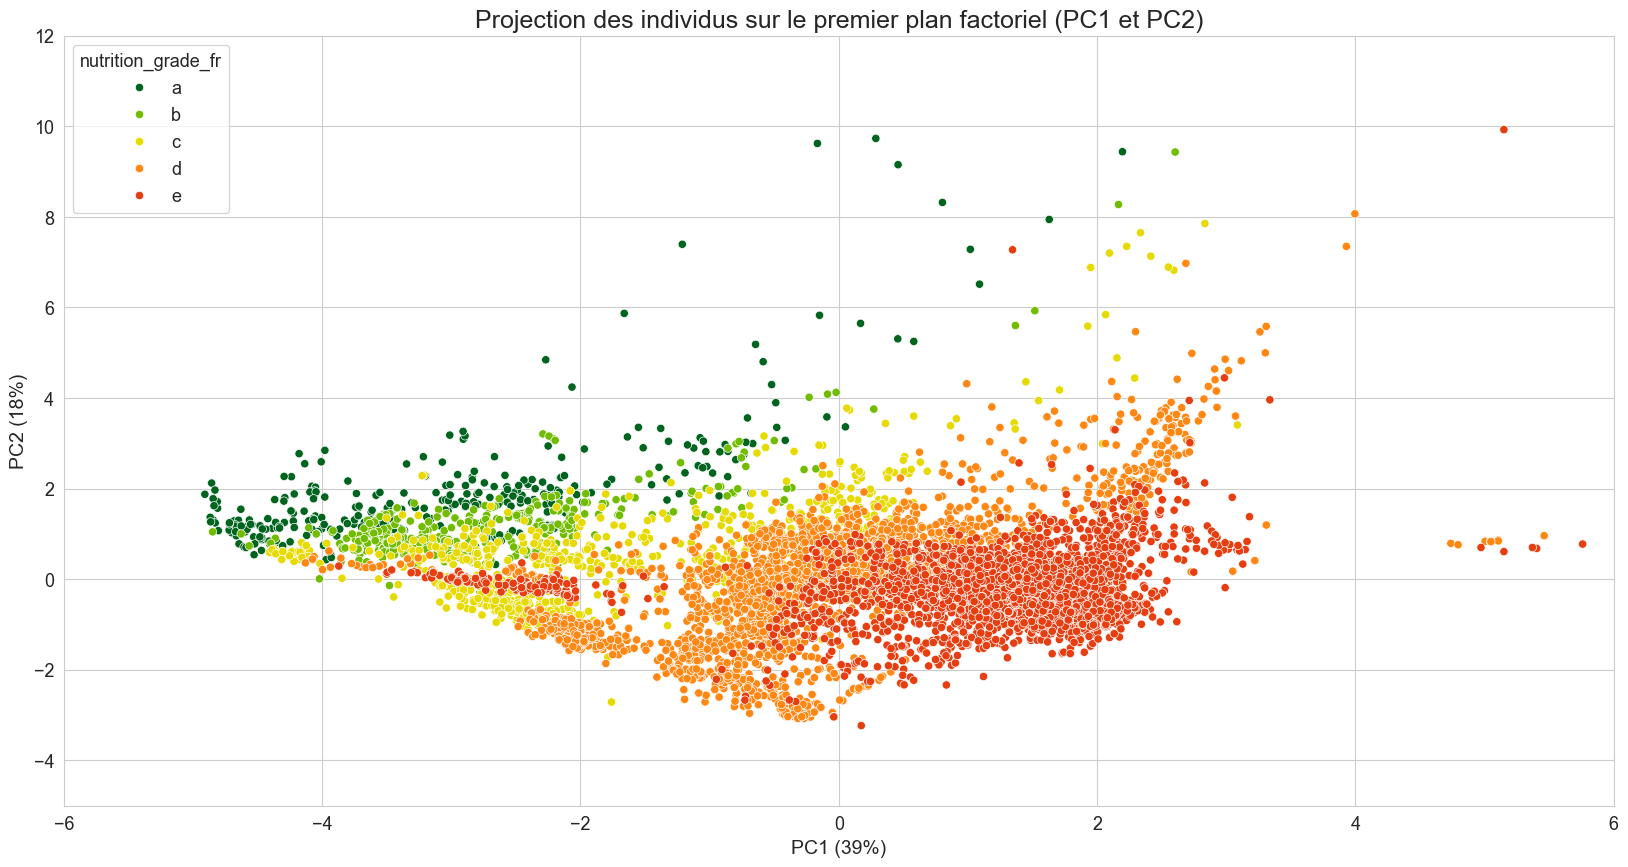

In [61]:
# Projection des individus sur le premier plan factoriel
fig, ax = plt.subplots(1,1, figsize=(20,10))

sns.scatterplot(data=None, 
                x=X_proj[:, 0],
                y=X_proj[:, 1], 
                hue=frfoodfacts_df_acp['nutrition_grade_fr'], 
                palette=['#00641E', '#72BC00', '#E7DA00', '#FF8714', '#E63E10'], ax=ax)# Affichage des individus


ax.set_xlabel(f"PC1 ({scree.iloc[0,2]:.0f}%)")
ax.set_ylabel(f"PC2 ({scree.iloc[1,2]:.0f}%)")
ax.set_title("Projection des individus sur le premier plan factoriel (PC1 et PC2)")
ax.legend(title='nutrition_grade_fr', loc='upper left')
plt.xlim(-6,6)
plt.ylim(-5,12)
plt.show()

Nous observons des individus qui sortent du lot.

In [62]:
# Produits avec PC1 > 4
frfoodfacts_df_acp.loc[X_proj[:, 0] > 4, ['product_name', 'pnns_groups_1', 'pnns_groups_2']]

product_name   pnns_groups_1  \
40831                          Huile vierge de coco  fat-and-sauces   
57332                          Huile vierge de Coco  fat-and-sauces   
51389  Huile de noix de coco biologique goût neutre  fat-and-sauces   
63708                  Huile vierge de noix de coco  fat-and-sauces   
63378                            extra virgin cocos  fat-and-sauces   
63933                  Végétaline (offre familiale)  fat-and-sauces   
10001              Huile vierge de Noix de Coco bio  fat-and-sauces   
9717                         Kokosolie Extra Virgin  fat-and-sauces   
34079       Huile de coco inodore - BioWise - 400 g  fat-and-sauces   
32469                          Huile vierge de coco  fat-and-sauces   
72375                                      Jog'Frit  fat-and-sauces   
28458                               graisse de coco  fat-and-sauces   
25938                  Huile vierge de noix de coco  fat-and-sauces   
3572                                  Kokosöl Nativ  fat-and-sauces   
3999                                   Sirop Fraise       beverages   
3156                                  Huile de coco  fat-and-sauces   
16376                             Frites & Fritures  fat-and-sauces   

               pnns_groups_2  
40831                   fats  
57332                   fats  
51389                   fats  
63708                   fats  
63378                   fats  
63933                   fats  
10001                   fats  
9717                    fats  
34079                   fats  
32469                   fats  
72375                   fats  
28458                   fats  
25938                   fats  
3572                    fats  
3999   non-sugared-beverages  
3156                    fats  
16376                   fats

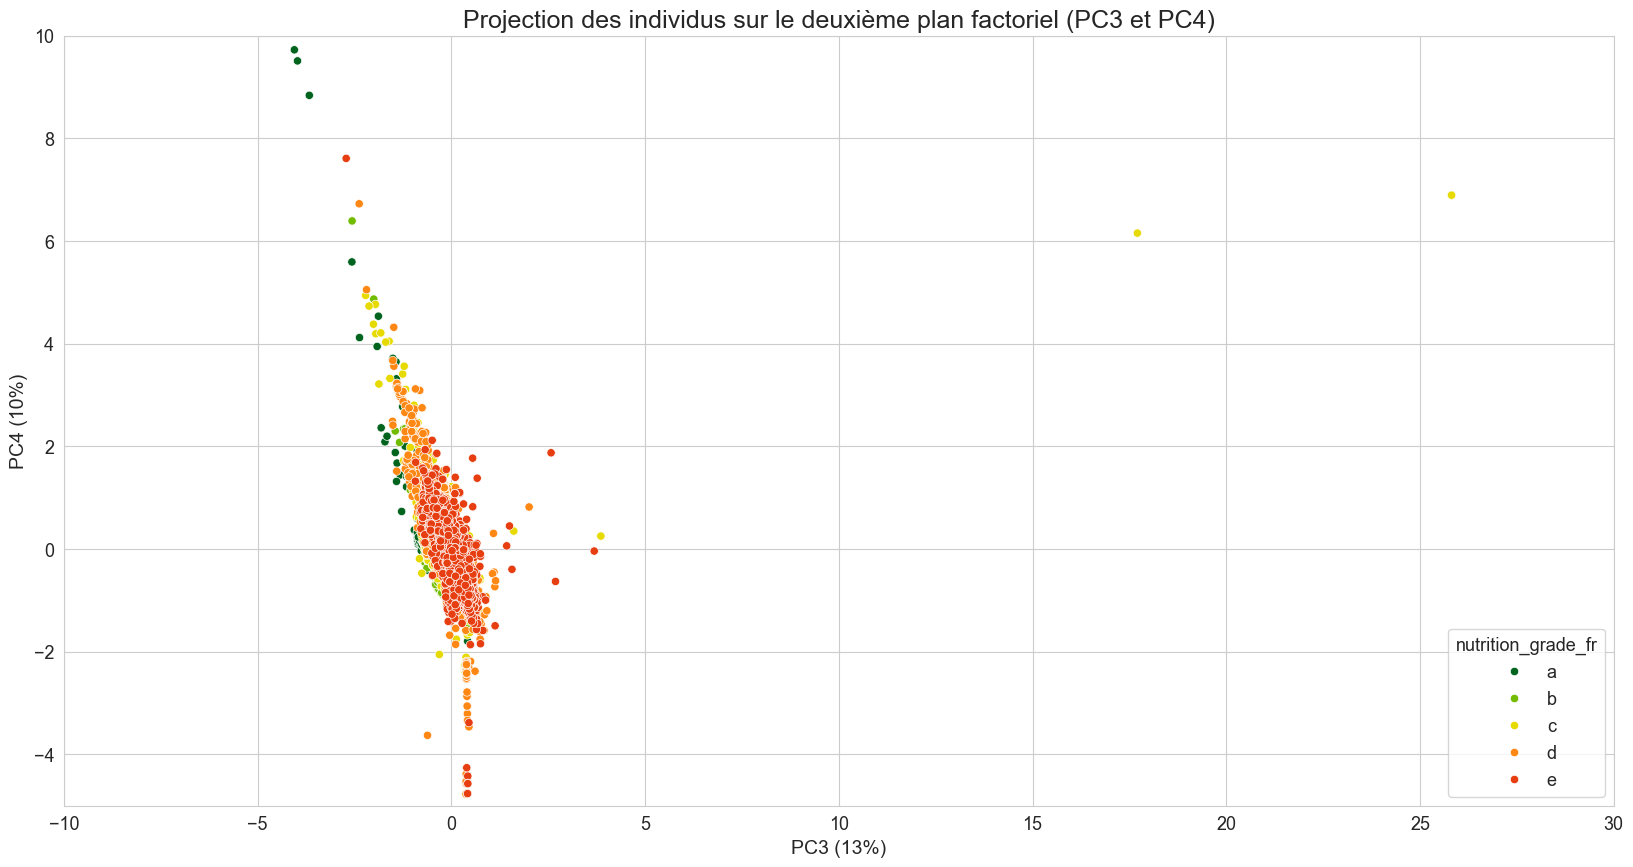

In [63]:
# Projection des individus sur le deuxième plan factoriel
fig, ax = plt.subplots(1,1, figsize=(20,10))

sns.scatterplot(data=None, 
                x=X_proj[:, 2],
                y=X_proj[:, 3],
                hue=frfoodfacts_df_acp['nutrition_grade_fr'], 
                palette=['#00641E', '#72BC00', '#E7DA00', '#FF8714', '#E63E10'], ax=ax)# Affichage des individus

ax.set_xlabel(f"PC3 ({scree.iloc[2,2]:.0f}%)")
ax.set_ylabel(f"PC4 ({scree.iloc[3,2]:.0f}%)")
ax.set_title("Projection des individus sur le deuxième plan factoriel (PC3 et PC4)")
ax.legend(title='nutrition_grade_fr', loc='lower right')
plt.xlim(-10,30)
plt.ylim(-5,10)
plt.show()

Nous observons des individus qui sortent du lot.

In [64]:
# Produits avec PC4 > 6
frfoodfacts_df_acp.loc[X_proj[:, 3] > 6, ['product_name', 'pnns_groups_1', 'pnns_groups_2']]

product_name  pnns_groups_1  \
31969                                               쌀떡  sugary-snacks   
79876  Carrés coupe faim minceur Cacao Gayelord Hauser  sugary-snacks   
65492                                       Stevi Drop  sugary-snacks   
72702                           Cacao maigre en poudre  sugary-snacks   
23106                         Fleur de sel de Guérande   salty-snacks   
17861                                  Saliere sel fin   salty-snacks   
21293                                  Sel de Guérande   salty-snacks   
16222                  Véritable sel de mer la baleine   salty-snacks   
35142                        Sel fin iodé - sel de mer   salty-snacks   
15331                           Sel Fin de l'Île de Ré   salty-snacks   
41985                 Jam YP LANDS - Quandong Preserve  sugary-snacks   
29682                                           Auchan   salty-snacks   
28588                                  Sel de Guérande   salty-snacks   
11470                           Moulin Sel de Guérande   salty-snacks   
4408                               Sel fin de met iodé   salty-snacks   
3072                               Sel fin de Guerande   salty-snacks   
5884                               Sel fin de Guérande   salty-snacks   
80821                                        Cacao cru  sugary-snacks   
1657                                            Ricoré      beverages   

               pnns_groups_2  
31969     biscuits-and-cakes  
79876     biscuits-and-cakes  
65492                 sweets  
72702     chocolate-products  
23106                  salts  
17861                  salts  
21293                  salts  
16222                  salts  
35142                  salts  
15331                  salts  
41985                 sweets  
29682                  salts  
28588                  salts  
11470                  salts  
4408                   salts  
3072                   salts  
5884                   salts  
80821     chocolate-products  
1657   non-sugared-beverages

In [65]:
# Projection sur les 3 premières composantes de l'ACP - graphique 3D - pnns_groups_1
fig = px.scatter_3d(
    X_proj[:,:3], x=0, y=1, z=2, color=frfoodfacts_df_acp['pnns_groups_1'],
    title=f'Projection des individus - Total Explained Variance: {scree.iloc[2,3]:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

## <font color='#46abe6'>3.4. Conclusion et perspectives<a class="anchor" id="3_4"></a></font>

**Conclusions de l'analyse exploratoire :** 
* Les produits les plus fréquents dans la base de données sont des produits de base.
* Les produits avec les meilleurs nutrigrades sont des aliments non ou peu transformés. Ceux avec les nutrigrades les plus bas sont transformés, riches en sucres ou en matières grasses.
* L'analyse des corrélations confirment ce qui a été observé lors du nettoyage : les liens entre les variables salt et sodium, fat et saturated_fat, carbohydrates et sugars.
* L'analyse et les tests statistiques montrent : 
    - une relation entre le groupe pnns et le nutrition_grade
    - une corrélation linéaire entre les matières grasses et l'énergie 
    - une influence de l'énergie sur le nutrition_grade
* La projection du nutrition grade sur le nuage de points du premier plan factoriel montre que la première composante PC1 permet bien d'expliquer le nutrition_grade. Les variables qui ont le mieux représentées sont dans l'ordre décroissant ((+) : corrélation positive, (-) corrélation négative ): 
    - sur PC1 : 'energy_100g' (+), 'nutrition-score-fr_100g' (+), 'saturated-fat_100g' (+), 'fruits-vegetables-nuts_100g' (-)
    - sur PC2 : 'sugars_100g' (-) , 'fiber_100g' (+), 'proteins_100g' (+)
    - sur PC3 : 'salt_100g'(+)
* Il reste encore beaucoup de valeurs atypiques dans les pnns_groups_1 :  une méthode du Z-score par groupe 'pnns_groups_1' et par variable nutritionnelle. 

**Perspectives :** 
* Des tests statistiques complémentaires pour étudier l'ensemble des relations entre les variables.
* Analyse de classification de type clustering pour identifier les groupes de produits et peut être détectée les erreurs de labellisation.
